다양한 기계학습 방법을 통해 online 뉴스 인기도 예측력를 극대화
 
최종 평가는 아래 test 데이터를 활용, 최종 예측 평가 지표는 MAE (Mean Absolute Error).

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from graphviz import Source
from IPython.display import Image
from sklearn.tree import export_graphviz

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

## for regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style("whitegrid")

In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
path = "onlinenews.csv"
data = pd.read_csv(path, engine='python')
print("- Data has {} rows and {} columns.".format(*data.shape))
print("- Column names: ", list(data.columns))

X = data.drop([' shares'], axis=1)
y = data[' shares']

- Data has 39644 rows and 60 columns.
- Column names:  [' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words', ' global

데이터 6:2:2 Train valid test 구분

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2015010720)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=2015010720)

# X_valid = scaler.transform(X_valid)

In [80]:
# 주어진 test_data.csv, valid_data.csv, train_data.csv 사용

train_df = pd.read_csv("train_data.csv")
valid_df = pd.read_csv("valid_Data.csv")
test_df  = pd.read_csv("test_data.csv")

X_train = train_df.drop(columns=[' shares'])
y_train = train_df[' shares']

X_valid = valid_df.drop(columns=[' shares'])
y_valid = valid_df[' shares']

X_test  = test_df.drop(columns=[' shares'])
y_test  = test_df[' shares']

최적 파라미터 조정 없이 학습 및 테스트 진행

In [81]:
clf_dt = DecisionTreeRegressor(criterion='squared_error', max_depth=None)
clf_dt.fit(X_train, y_train)
y_train_pred = clf_dt.predict(X_train)
y_valid_pred = clf_dt.predict(X_valid)
y_test_pred = clf_dt.predict(X_test)

In [82]:
# Show train & validation accuracies
print('- MSE (Train)      : {:.4}'.format(mean_squared_error(y_train, y_train_pred)))
print('- MSE (Validation) : {:.4}'.format(mean_squared_error(y_valid, y_valid_pred)))
print('- MSE (test) : {:.4}'.format(mean_squared_error(y_test, y_test_pred)))
print('- MAE (Train)      : {:.4}'.format(mean_absolute_error(y_train, y_train_pred)))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_valid, y_valid_pred))))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_test, y_test_pred))))

- MSE (Train)      : 0.0
- MSE (Validation) : 2.405e+08
- MSE (test) : 5.189e+08
- MAE (Train)      : 0.0
- MAE (Validation) : 4212
- MAE (Validation) : 4673


---

### EDA

In [83]:
# 기초 통계 및 결측치 확인
print("=== X 요약 통계 ===")
print(X.describe().T)
print("\n=== y 요약 통계 ===")
print(y.describe())
print("\n=== 결측치 개수 ===")
na_X = X.isna().sum()
na_y = pd.Series({'y': y.isna().sum()})
print(pd.concat([na_X, na_y], axis=1, keys=['X','y']))

=== X 요약 통계 ===
                                 count           mean            std      min  \
timedelta                      39644.0     354.530471     214.163767  8.00000   
n_tokens_title                 39644.0      10.398749       2.114037  2.00000   
n_tokens_content               39644.0     546.514731     471.107508  0.00000   
n_unique_tokens                39644.0       0.548216       3.520708  0.00000   
n_non_stop_words               39644.0       0.996469       5.231231  0.00000   
n_non_stop_unique_tokens       39644.0       0.689175       3.264816  0.00000   
num_hrefs                      39644.0      10.883690      11.332017  0.00000   
num_self_hrefs                 39644.0       3.293638       3.855141  0.00000   
num_imgs                       39644.0       4.544143       8.309434  0.00000   
num_videos                     39644.0       1.249874       4.107855  0.00000   
average_token_length           39644.0       4.548239       0.844406  0.00000   
num_keywords

Skewness of y: 33.9639


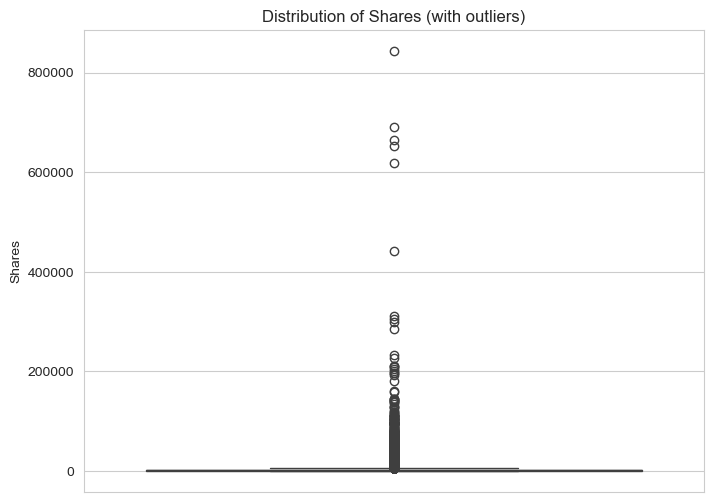

In [74]:
# y 왜도 계산 및 이상치 파악 (전체)
skewness = y.skew()
print(f'Skewness of y: {skewness:.4f}')
      
plt.figure(figsize=(8, 6))
sns.boxplot(y=y)
plt.title('Distribution of Shares (with outliers)')
plt.ylabel('Shares')
plt.show()


=== X feature skewness ===
n_non_stop_words                 198.792445
n_unique_tokens                  198.655116
n_non_stop_unique_tokens         198.443294
kw_max_min                        35.328434
kw_avg_min                        31.306108
self_reference_min_shares         26.264364
self_reference_avg_sharess        17.914093
kw_max_avg                        16.411670
self_reference_max_shares         13.870849
kw_min_max                        10.386372
num_videos                         7.019533
kw_avg_avg                         5.760177
num_self_hrefs                     5.172751
num_hrefs                          4.013495
data_channel_is_lifestyle          3.993019
num_imgs                           3.946596
data_channel_is_socmed             3.758880
weekday_is_saturday                3.637086
weekday_is_sunday                  3.399927
min_positive_polarity              3.040468
n_tokens_content                   2.945422
kw_min_min                         2.374947
is_w

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3812532366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skewness.values, y=skewness.index, palette='viridis')


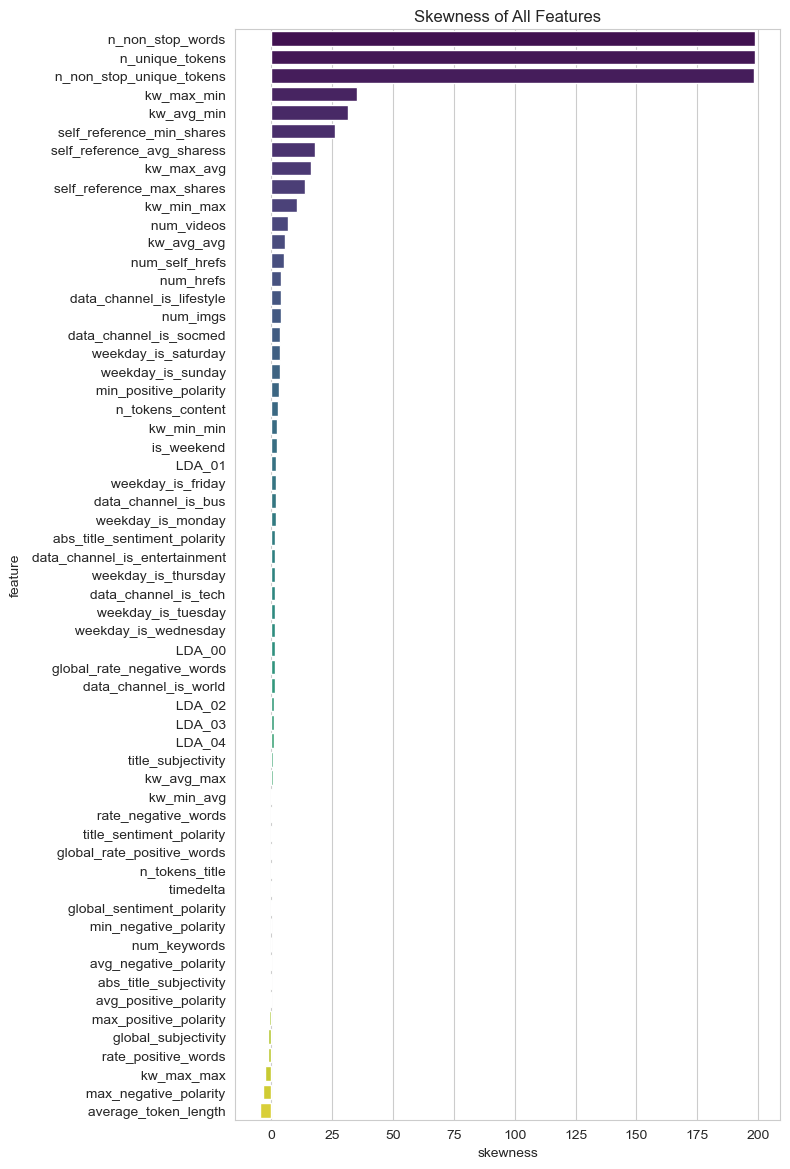

In [75]:
# X 모든 특성의 왜도 계산 및 시각화 (전체)
skewness = X.skew().sort_values(ascending=False)
print("\n=== X feature skewness ===")
print(skewness)
plt.figure(figsize=(8, len(skewness)*0.2))
sns.barplot(x=skewness.values, y=skewness.index, palette='viridis')
plt.title('Skewness of All Features')
plt.xlabel('skewness')
plt.ylabel('feature')
plt.tight_layout()
plt.show()

In [76]:
# 피처와 타켓 사이의 상관관계
corrs = X.apply(lambda col: y.corr(col))
corrs_abs = corrs.abs().sort_values(ascending=False)

corrs_abs.head(10)

kw_avg_avg                    0.110413
LDA_03                        0.083771
kw_max_avg                    0.064306
LDA_02                        0.059163
self_reference_avg_sharess    0.057789
self_reference_min_shares     0.055958
data_channel_is_world         0.049497
self_reference_max_shares     0.047115
num_hrefs                     0.045404
kw_avg_max                    0.044686
dtype: float64

---

### 피처 엔지니어링

In [84]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.ensemble import RandomForestRegressor

# 분할된 각각의 세트에 동일한 피처 엔지니어링 함수 정의
def engineer_features(df):
    df = df.copy()
    # 2-1) 고왜도 컬럼 찾아서 √, ³√ 추가
    skews = df.skew().abs()
    high_skew = skews[skews > 1].index
    for col in high_skew:
        df[f"{col}_sqrt"] = np.sqrt(df[col])
        df[f"{col}_cbrt"] = np.cbrt(df[col])
    # 2-2) 상위 5개 왜도 컬럼 간 곱셈·나눗셈 항 추가
    top5 = list(high_skew.sort_values(ascending=False)[:5])
    for i, a in enumerate(top5):
        for b in top5[i+1:]:
            df[f"{a}_x_{b}"] = df[a] * df[b]
            df[f"{a}_div_{b}"] = np.where(df[b]==0, 0, df[a] / df[b])

            # 클리핑
            low, high = np.percentile(df[f"{a}_div_{b}"], [0.1, 99.9])
            df[f"{a}_div_{b}"] = df[f"{a}_div_{b}"].clip(low, high)

    return df

# 각 세트에 피처 엔지니어링 적용
X_train_fe = engineer_features(X_train)
X_valid_fe = engineer_features(X_valid)
X_test_fe  = engineer_features(X_test)

# 결측치 대체 — 중앙값으로
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_fe)
X_valid_imp = imputer.transform(X_valid_fe)
X_test_imp  = imputer.transform(X_test_fe)

# DataFrame 형태로 복원
X_train_df = pd.DataFrame(X_train_imp, columns=X_train_fe.columns, index=X_train.index)
X_valid_df = pd.DataFrame(X_valid_imp, columns=X_train_fe.columns, index=X_valid.index)
X_test_df  = pd.DataFrame(X_test_imp,  columns=X_train_fe.columns, index=X_test.index)


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/2714025597.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{a}_x_{b}"] = df[a] * df[b]

---

### 모델 + 이상치제거, x,y 로그변환, PowerTransformer 조합 분석

In [85]:
from sklearn.base import clone
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# 1) 실행할 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=50, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42, verbosity=0),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=False)
}

# 2) 전처리 조합 리스트 (use_log: x+y 로그 변환, use_pt: PowerTransformer)
combos = [
    {'name': 'raw',                  'remove_pct': None,    'use_iqr': False, 'use_log': False, 'use_pt': False},
    {'name': 'logXY',                'remove_pct': None,    'use_iqr': False, 'use_log': True,  'use_pt': False},
    {'name': 'PT only',              'remove_pct': None,    'use_iqr': False, 'use_log': False, 'use_pt': True},
    {'name': 'logXY + PT',           'remove_pct': None,    'use_iqr': False, 'use_log': True,  'use_pt': True},
    {'name': 'remove 1%',            'remove_pct': 0.99,    'use_iqr': False, 'use_log': False, 'use_pt': False},
    {'name': 'remove 1% + logXY',    'remove_pct': 0.99,    'use_iqr': False, 'use_log': True,  'use_pt': False},
    {'name': 'remove 1% + PT',       'remove_pct': 0.99,    'use_iqr': False, 'use_log': False, 'use_pt': True},
    {'name': 'remove 1% + logXY+PT', 'remove_pct': 0.99,    'use_iqr': False, 'use_log': True,  'use_pt': True},
    {'name': 'remove 0.5%',          'remove_pct': 0.995,   'use_iqr': False, 'use_log': False, 'use_pt': False},
    {'name': 'remove 0.5%+logXY',    'remove_pct': 0.995,   'use_iqr': False, 'use_log': True,  'use_pt': False},
    {'name': 'remove 0.5%+PT',       'remove_pct': 0.995,   'use_iqr': False, 'use_log': False, 'use_pt': True},
    {'name': 'remove0.5%+logXY+PT',  'remove_pct': 0.995,   'use_iqr': False, 'use_log': True,  'use_pt': True},
    {'name': 'IQR',                  'remove_pct': None,    'use_iqr': True,  'use_log': False, 'use_pt': False},
    {'name': 'IQR + logXY',          'remove_pct': None,    'use_iqr': True,  'use_log': True,  'use_pt': False},
    {'name': 'IQR + PT',             'remove_pct': None,    'use_iqr': True,  'use_log': False, 'use_pt': True},
    {'name': 'IQR+logXY+PT',         'remove_pct': None,    'use_iqr': True,  'use_log': True,  'use_pt': True}
]

# 3) 전처리·평가 함수 (이상치제거 → x/y 로그 → PT → 학습 → y 복원 → 평가)
def preprocess_and_eval(model, X_tr, y_tr, X_te, y_te,
                        remove_pct=None, use_iqr=False,
                        use_log=False, use_pt=False):
    Xc, yc = X_tr.copy(), y_tr.copy()

    # 1) 이상치 제거 (y 기준)
    if use_iqr:
        Q1, Q3 = np.percentile(yc, [25, 75])
        mask = (yc >= Q1 - 1.5*(Q3-Q1)) & (yc <= Q3 + 1.5*(Q3-Q1))
        Xc, yc = Xc[mask], yc[mask]
    elif remove_pct is not None:
        thresh = np.percentile(yc, remove_pct*100)
        mask = yc <= thresh
        Xc, yc = Xc[mask], yc[mask]

    # 2) 로그 변환 (x는 skew>1 & non-negative 컬럼만, y 전체)
    if use_log:
        # y 로그
        yc = np.log1p(yc)
        # x selective 로그
        skew_cols = Xc.columns[(Xc.skew().abs() > 1) & (Xc.min() >= 0)]
        Xc[skew_cols] = np.log1p(Xc[skew_cols])
        Xc = np.nan_to_num(Xc, neginf=0, posinf=0)

    # 3) PowerTransformer (x)
    if use_pt:
        pt = PowerTransformer(method='yeo-johnson')
        Xc = pt.fit_transform(Xc)
        Xc = np.nan_to_num(Xc, neginf=0, posinf=0)
        # test에도 동일 변환
        Xte = X_te.copy()
        if use_log:
            Xte[skew_cols] = np.log1p(Xte[skew_cols])
        Xte = pt.transform(np.nan_to_num(Xte, neginf=0, posinf=0))
    else:
        Xte = X_te.copy()
        if use_log:
            Xte[skew_cols] = np.log1p(Xte[skew_cols])
            Xte = np.nan_to_num(Xte, neginf=0, posinf=0)


    # 4) 학습·예측
    clf = clone(model)
    clf.fit(Xc, yc)
    y_pred_log = clf.predict(Xte)

    # 5) y 복원
    if use_log:
        y_pred = np.expm1(y_pred_log)
    else:
        y_pred = y_pred_log

    # 6) 평가
    return mean_squared_error(y_te, y_pred), mean_absolute_error(y_te, y_pred)

# 4) 일괄 실행 및 결과 수집
results = []
for model_name, model in models.items():
    print(f'\n=== {model_name} ===')
    for combo in tqdm(combos, desc=model_name):
        mse, mae = preprocess_and_eval(
            model, 
            # X_train,
            X_train_df,
            y_train, 
            # X_test, 
            X_test_df,
            y_test,
            remove_pct=combo['remove_pct'],
            use_iqr=combo['use_iqr'],
            use_log=combo['use_log'],
            use_pt=combo['use_pt']
        )
        print(f"{combo['name']:20s} → MSE: {mse:.4e}, MAE: {mae:.4f}")
        results.append({
            'model': model_name,
            'combo': combo['name'],
            'MSE': mse,
            'MAE': mae
        })

# 5) DataFrame 변환, MAE 기준 정렬
df = pd.DataFrame(results).sort_values(by='MAE', ascending=True)


=== LinearRegression ===


LinearRegression:   0%|          | 0/16 [00:00<?, ?it/s]

raw                  → MSE: 1.4565e+08, MAE: 3134.6631


LinearRegression:  12%|█▎        | 2/16 [00:00<00:02,  5.08it/s]

logXY                → MSE: 1.5198e+08, MAE: 2364.2544


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  19%|█▉        | 3/16 [00:01<00:06,  1.98it/s]

PT only              → MSE: 1.4624e+08, MAE: 3173.1492


LinearRegression:  31%|███▏      | 5/16 [00:02<00:05,  2.02it/s]

logXY + PT           → MSE: 1.4825e+08, MAE: 2343.1265
remove 1%            → MSE: 1.4571e+08, MAE: 2614.2614


LinearRegression:  38%|███▊      | 6/16 [00:02<00:04,  2.47it/s]

remove 1% + logXY    → MSE: 2.4794e+08, MAE: 2442.1258


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  44%|████▍     | 7/16 [00:03<00:05,  1.74it/s]

remove 1% + PT       → MSE: 1.4579e+08, MAE: 2612.5535


LinearRegression:  50%|█████     | 8/16 [00:04<00:05,  1.36it/s]

remove 1% + logXY+PT → MSE: 1.4874e+08, MAE: 2330.9862
remove 0.5%          → MSE: 1.4526e+08, MAE: 2707.8377


LinearRegression:  62%|██████▎   | 10/16 [00:04<00:02,  2.20it/s]

remove 0.5%+logXY    → MSE: 1.5776e+08, MAE: 2369.5837


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  69%|██████▉   | 11/16 [00:05<00:02,  1.77it/s]

remove 0.5%+PT       → MSE: 1.4537e+08, MAE: 2706.2621


LinearRegression:  81%|████████▏ | 13/16 [00:06<00:01,  1.96it/s]

remove0.5%+logXY+PT  → MSE: 1.4854e+08, MAE: 2336.2229
IQR                  → MSE: 1.4983e+08, MAE: 2342.7654


LinearRegression:  88%|████████▊ | 14/16 [00:07<00:00,  2.31it/s]

IQR + logXY          → MSE: 2.0305e+08, MAE: 2409.7474


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  94%|█████████▍| 15/16 [00:08<00:00,  1.79it/s]

IQR + PT             → MSE: 1.4983e+08, MAE: 2340.3535


LinearRegression: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


IQR+logXY+PT         → MSE: 1.5083e+08, MAE: 2330.1110

=== Ridge ===


Ridge:  12%|█▎        | 2/16 [00:00<00:00, 16.27it/s]

raw                  → MSE: 1.4544e+08, MAE: 3096.7168
logXY                → MSE: 1.4839e+08, MAE: 2346.8662


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


PT only              → MSE: 1.4543e+08, MAE: 3111.4628


Ridge:  38%|███▊      | 6/16 [00:02<00:03,  3.08it/s]

logXY + PT           → MSE: 1.4833e+08, MAE: 2345.5057
remove 1%            → MSE: 1.4571e+08, MAE: 2613.4842
remove 1% + logXY    → MSE: 1.4886e+08, MAE: 2334.9280


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


remove 1% + PT       → MSE: 1.4585e+08, MAE: 2620.8331


Ridge:  62%|██████▎   | 10/16 [00:03<00:02,  2.65it/s]

remove 1% + logXY+PT → MSE: 1.4881e+08, MAE: 2334.0253
remove 0.5%          → MSE: 1.4528e+08, MAE: 2708.2515
remove 0.5%+logXY    → MSE: 1.4866e+08, MAE: 2340.1420


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
Ridge:  69%|██████▉   | 11/16 [00:04<00:02,  2.06it/s]

remove 0.5%+PT       → MSE: 1.4540e+08, MAE: 2715.1872


Ridge:  88%|████████▊ | 14/16 [00:05<00:00,  2.61it/s]

remove0.5%+logXY+PT  → MSE: 1.4861e+08, MAE: 2339.0107
IQR                  → MSE: 1.4984e+08, MAE: 2343.3220
IQR + logXY          → MSE: 1.5091e+08, MAE: 2333.8264


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
Ridge:  94%|█████████▍| 15/16 [00:06<00:00,  2.16it/s]

IQR + PT             → MSE: 1.4989e+08, MAE: 2347.2373


Ridge: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


IQR+logXY+PT         → MSE: 1.5089e+08, MAE: 2333.1444

=== Lasso ===


Lasso:   0%|          | 0/16 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+12, tolerance: 3.516e+08
  model = cd_fast.enet_coordinate_descent(
Lasso:  12%|█▎        | 2/16 [00:06<00:40,  2.89s/it]

raw                  → MSE: 1.4540e+08, MAE: 3076.1862
logXY                → MSE: 1.5016e+08, MAE: 2451.7893


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.372e+11, tolerance: 3.516e+08
  model = cd_fast.enet_coordinate_descent(
Lasso:  19%|█▉        | 3/16 [00:12<00:55,  4.24s/it]

PT only              → MSE: 1.4535e+08, MAE: 3094.8434


Lasso:  25%|██▌       | 4/16 [00:13<00:35,  2.94s/it]

logXY + PT           → MSE: 1.5039e+08, MAE: 2463.6460


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+11, tolerance: 3.173e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  38%|███▊      | 6/16 [00:18<00:25,  2.50s/it]

remove 1%            → MSE: 1.4580e+08, MAE: 2613.8896
remove 1% + logXY    → MSE: 1.5041e+08, MAE: 2440.0053


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+10, tolerance: 3.173e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  44%|████▍     | 7/16 [00:23<00:29,  3.28s/it]

remove 1% + PT       → MSE: 1.4599e+08, MAE: 2633.6317


Lasso:  50%|█████     | 8/16 [00:24<00:20,  2.53s/it]

remove 1% + logXY+PT → MSE: 1.5059e+08, MAE: 2451.9822


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.334e+11, tolerance: 5.059e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  62%|██████▎   | 10/16 [00:29<00:13,  2.20s/it]

remove 0.5%          → MSE: 1.4532e+08, MAE: 2706.9781
remove 0.5%+logXY    → MSE: 1.5030e+08, MAE: 2445.3367


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.856e+10, tolerance: 5.059e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  69%|██████▉   | 11/16 [00:34<00:15,  3.18s/it]

remove 0.5%+PT       → MSE: 1.4551e+08, MAE: 2724.6575


Lasso:  75%|███████▌  | 12/16 [00:35<00:09,  2.48s/it]

remove0.5%+logXY+PT  → MSE: 1.5050e+08, MAE: 2457.2591


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+10, tolerance: 2.586e+06
  model = cd_fast.enet_coordinate_descent(
Lasso:  88%|████████▊ | 14/16 [00:39<00:04,  2.14s/it]

IQR                  → MSE: 1.4989e+08, MAE: 2347.4272
IQR + logXY          → MSE: 1.5170e+08, MAE: 2420.4735


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e+08, tolerance: 2.586e+06
  model = cd_fast.enet_coordinate_descent(
Lasso:  94%|█████████▍| 15/16 [00:44<00:02,  2.82s/it]

IQR + PT             → MSE: 1.4998e+08, MAE: 2358.8383


Lasso: 100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


IQR+logXY+PT         → MSE: 1.5177e+08, MAE: 2428.6351

=== KNeighbors ===


KNeighbors:   6%|▋         | 1/16 [00:00<00:06,  2.35it/s]

raw                  → MSE: 1.5835e+08, MAE: 3230.4227


KNeighbors:  12%|█▎        | 2/16 [00:00<00:04,  2.82it/s]

logXY                → MSE: 1.5027e+08, MAE: 2582.6228


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  19%|█▉        | 3/16 [00:01<00:08,  1.48it/s]

PT only              → MSE: 1.5660e+08, MAE: 3152.1144


KNeighbors:  25%|██▌       | 4/16 [00:02<00:10,  1.17it/s]

logXY + PT           → MSE: 1.4841e+08, MAE: 2474.2281


KNeighbors:  31%|███▏      | 5/16 [00:03<00:06,  1.58it/s]

remove 1%            → MSE: 1.4965e+08, MAE: 2838.0853


KNeighbors:  38%|███▊      | 6/16 [00:03<00:05,  1.92it/s]

remove 1% + logXY    → MSE: 1.5024e+08, MAE: 2534.3912


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]

remove 1% + PT       → MSE: 1.4709e+08, MAE: 2707.1811


KNeighbors:  50%|█████     | 8/16 [00:05<00:06,  1.23it/s]

remove 1% + logXY+PT → MSE: 1.4864e+08, MAE: 2435.8264


KNeighbors:  56%|█████▋    | 9/16 [00:05<00:04,  1.55it/s]

remove 0.5%          → MSE: 1.5064e+08, MAE: 2963.5503


KNeighbors:  62%|██████▎   | 10/16 [00:06<00:03,  1.85it/s]

remove 0.5%+logXY    → MSE: 1.5026e+08, MAE: 2557.1855


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  69%|██████▉   | 11/16 [00:07<00:03,  1.46it/s]

remove 0.5%+PT       → MSE: 1.4789e+08, MAE: 2819.3343


KNeighbors:  75%|███████▌  | 12/16 [00:08<00:03,  1.25it/s]

remove0.5%+logXY+PT  → MSE: 1.4853e+08, MAE: 2449.2104


KNeighbors:  81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]

IQR                  → MSE: 1.5050e+08, MAE: 2450.1820


KNeighbors:  88%|████████▊ | 14/16 [00:08<00:01,  1.93it/s]

IQR + logXY          → MSE: 1.5149e+08, MAE: 2453.4059


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  94%|█████████▍| 15/16 [00:09<00:00,  1.53it/s]

IQR + PT             → MSE: 1.5023e+08, MAE: 2390.8025


KNeighbors: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


IQR+logXY+PT         → MSE: 1.5087e+08, MAE: 2384.2387

=== DecisionTree ===


DecisionTree:   6%|▋         | 1/16 [00:02<00:38,  2.54s/it]

raw                  → MSE: 3.7217e+08, MAE: 4496.9555


DecisionTree:  12%|█▎        | 2/16 [00:04<00:29,  2.11s/it]

logXY                → MSE: 2.8166e+08, MAE: 3981.0349


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  19%|█▉        | 3/16 [00:07<00:34,  2.67s/it]

PT only              → MSE: 4.7643e+08, MAE: 4714.6481


DecisionTree:  25%|██▌       | 4/16 [00:10<00:31,  2.66s/it]

logXY + PT           → MSE: 3.4124e+08, MAE: 4096.7465


DecisionTree:  31%|███▏      | 5/16 [00:12<00:27,  2.48s/it]

remove 1%            → MSE: 1.6069e+08, MAE: 3366.7118


DecisionTree:  38%|███▊      | 6/16 [00:14<00:22,  2.27s/it]

remove 1% + logXY    → MSE: 1.5858e+08, MAE: 3288.8057


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  44%|████▍     | 7/16 [00:17<00:22,  2.49s/it]

remove 1% + PT       → MSE: 1.6049e+08, MAE: 3386.5026


DecisionTree:  50%|█████     | 8/16 [00:19<00:20,  2.53s/it]

remove 1% + logXY+PT → MSE: 1.5898e+08, MAE: 3289.5986


DecisionTree:  56%|█████▋    | 9/16 [00:22<00:17,  2.46s/it]

remove 0.5%          → MSE: 1.6894e+08, MAE: 3669.2950


DecisionTree:  62%|██████▎   | 10/16 [00:24<00:13,  2.26s/it]

remove 0.5%+logXY    → MSE: 1.6989e+08, MAE: 3577.0957


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  69%|██████▉   | 11/16 [00:27<00:12,  2.50s/it]

remove 0.5%+PT       → MSE: 1.6895e+08, MAE: 3668.4381


DecisionTree:  75%|███████▌  | 12/16 [00:29<00:10,  2.59s/it]

remove0.5%+logXY+PT  → MSE: 1.7001e+08, MAE: 3559.5414


DecisionTree:  81%|████████▏ | 13/16 [00:31<00:06,  2.31s/it]

IQR                  → MSE: 1.5105e+08, MAE: 2604.5421


DecisionTree:  88%|████████▊ | 14/16 [00:33<00:04,  2.08s/it]

IQR + logXY          → MSE: 1.5075e+08, MAE: 2582.6113


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  94%|█████████▍| 15/16 [00:35<00:02,  2.17s/it]

IQR + PT             → MSE: 1.5070e+08, MAE: 2592.8170


DecisionTree: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it]


IQR+logXY+PT         → MSE: 1.5086e+08, MAE: 2594.9026

=== ExtraTrees ===


ExtraTrees:   6%|▋         | 1/16 [00:19<04:47, 19.14s/it]

raw                  → MSE: 1.5494e+08, MAE: 3431.6075


ExtraTrees:  12%|█▎        | 2/16 [00:36<04:14, 18.19s/it]

logXY                → MSE: 1.4734e+08, MAE: 2358.0889


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  19%|█▉        | 3/16 [00:56<04:06, 18.98s/it]

PT only              → MSE: 1.5574e+08, MAE: 3432.1006


ExtraTrees:  25%|██▌       | 4/16 [01:14<03:43, 18.59s/it]

logXY + PT           → MSE: 1.4761e+08, MAE: 2366.0376


ExtraTrees:  31%|███▏      | 5/16 [01:31<03:18, 18.02s/it]

remove 1%            → MSE: 1.4544e+08, MAE: 2755.9373


ExtraTrees:  38%|███▊      | 6/16 [01:47<02:54, 17.40s/it]

remove 1% + logXY    → MSE: 1.4819e+08, MAE: 2345.0243


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  44%|████▍     | 7/16 [02:06<02:40, 17.86s/it]

remove 1% + PT       → MSE: 1.4530e+08, MAE: 2757.0700


ExtraTrees:  50%|█████     | 8/16 [02:24<02:22, 17.75s/it]

remove 1% + logXY+PT → MSE: 1.4816e+08, MAE: 2348.6129


ExtraTrees:  56%|█████▋    | 9/16 [02:41<02:03, 17.64s/it]

remove 0.5%          → MSE: 1.4557e+08, MAE: 2914.6671


ExtraTrees:  62%|██████▎   | 10/16 [02:58<01:43, 17.29s/it]

remove 0.5%+logXY    → MSE: 1.4807e+08, MAE: 2353.0853


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  69%|██████▉   | 11/16 [03:16<01:28, 17.78s/it]

remove 0.5%+PT       → MSE: 1.4567e+08, MAE: 2898.2558


ExtraTrees:  75%|███████▌  | 12/16 [03:34<01:11, 17.75s/it]

remove0.5%+logXY+PT  → MSE: 1.4776e+08, MAE: 2350.3852


ExtraTrees:  81%|████████▏ | 13/16 [03:48<00:49, 16.55s/it]

IQR                  → MSE: 1.4956e+08, MAE: 2350.1267


ExtraTrees:  88%|████████▊ | 14/16 [04:02<00:31, 15.75s/it]

IQR + logXY          → MSE: 1.5078e+08, MAE: 2331.7341


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  94%|█████████▍| 15/16 [04:17<00:15, 15.59s/it]

IQR + PT             → MSE: 1.4960e+08, MAE: 2355.4678


ExtraTrees: 100%|██████████| 16/16 [04:33<00:00, 17.08s/it]


IQR+logXY+PT         → MSE: 1.5077e+08, MAE: 2331.5816

=== RandomForest ===


RandomForest:   6%|▋         | 1/16 [01:19<19:52, 79.49s/it]

raw                  → MSE: 1.5664e+08, MAE: 3416.3744


RandomForest:  12%|█▎        | 2/16 [02:12<14:52, 63.73s/it]

logXY                → MSE: 1.4794e+08, MAE: 2372.4883


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  19%|█▉        | 3/16 [03:31<15:19, 70.73s/it]

PT only              → MSE: 1.5684e+08, MAE: 3430.6309


RandomForest:  25%|██▌       | 4/16 [04:25<12:50, 64.22s/it]

logXY + PT           → MSE: 1.4788e+08, MAE: 2369.8289


RandomForest:  31%|███▏      | 5/16 [05:31<11:52, 64.77s/it]

remove 1%            → MSE: 1.4613e+08, MAE: 2767.2156


RandomForest:  38%|███▊      | 6/16 [06:23<10:06, 60.63s/it]

remove 1% + logXY    → MSE: 1.4857e+08, MAE: 2350.5291


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  44%|████▍     | 7/16 [07:31<09:27, 63.09s/it]

remove 1% + PT       → MSE: 1.4618e+08, MAE: 2776.9177


RandomForest:  50%|█████     | 8/16 [08:24<07:58, 59.84s/it]

remove 1% + logXY+PT → MSE: 1.4847e+08, MAE: 2348.6959


RandomForest:  56%|█████▋    | 9/16 [09:33<07:17, 62.55s/it]

remove 0.5%          → MSE: 1.4642e+08, MAE: 2928.7047


RandomForest:  62%|██████▎   | 10/16 [10:25<05:55, 59.23s/it]

remove 0.5%+logXY    → MSE: 1.4825e+08, MAE: 2359.4418


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  69%|██████▉   | 11/16 [11:35<05:13, 62.60s/it]

remove 0.5%+PT       → MSE: 1.4680e+08, MAE: 2936.0602


RandomForest:  75%|███████▌  | 12/16 [12:32<04:03, 60.78s/it]

remove0.5%+logXY+PT  → MSE: 1.4819e+08, MAE: 2357.5721


RandomForest:  81%|████████▏ | 13/16 [13:21<02:51, 57.29s/it]

IQR                  → MSE: 1.4962e+08, MAE: 2354.5530


RandomForest:  88%|████████▊ | 14/16 [14:05<01:46, 53.45s/it]

IQR + logXY          → MSE: 1.5082e+08, MAE: 2333.0733


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  94%|█████████▍| 15/16 [14:58<00:53, 53.16s/it]

IQR + PT             → MSE: 1.4962e+08, MAE: 2354.9313


RandomForest: 100%|██████████| 16/16 [15:44<00:00, 59.01s/it]


IQR+logXY+PT         → MSE: 1.5077e+08, MAE: 2331.8279

=== AdaBoost ===


AdaBoost:   6%|▋         | 1/16 [00:07<01:47,  7.14s/it]

raw                  → MSE: 1.1863e+09, MAE: 30999.4476


AdaBoost:  12%|█▎        | 2/16 [00:15<01:48,  7.75s/it]

logXY                → MSE: 1.4656e+08, MAE: 2821.6026


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  19%|█▉        | 3/16 [00:23<01:40,  7.75s/it]

PT only              → MSE: 8.2608e+08, MAE: 26186.7801


AdaBoost:  25%|██▌       | 4/16 [00:32<01:38,  8.25s/it]

logXY + PT           → MSE: 1.4648e+08, MAE: 3011.9377


AdaBoost:  31%|███▏      | 5/16 [00:35<01:10,  6.43s/it]

remove 1%            → MSE: 1.5034e+08, MAE: 4389.1311


AdaBoost:  38%|███▊      | 6/16 [00:43<01:08,  6.87s/it]

remove 1% + logXY    → MSE: 1.4813e+08, MAE: 2469.5948


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  44%|████▍     | 7/16 [00:47<00:53,  5.95s/it]

remove 1% + PT       → MSE: 1.5034e+08, MAE: 4389.1311


AdaBoost:  50%|█████     | 8/16 [00:55<00:53,  6.73s/it]

remove 1% + logXY+PT → MSE: 1.4774e+08, MAE: 2506.8764


AdaBoost:  56%|█████▋    | 9/16 [00:58<00:39,  5.67s/it]

remove 0.5%          → MSE: 1.6157e+08, MAE: 5653.2163


AdaBoost:  62%|██████▎   | 10/16 [01:06<00:37,  6.31s/it]

remove 0.5%+logXY    → MSE: 1.4694e+08, MAE: 2657.1765


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  69%|██████▉   | 11/16 [01:12<00:30,  6.10s/it]

remove 0.5%+PT       → MSE: 1.6885e+08, MAE: 6168.0489


AdaBoost:  75%|███████▌  | 12/16 [01:20<00:27,  6.83s/it]

remove0.5%+logXY+PT  → MSE: 1.4707e+08, MAE: 2618.4494


AdaBoost:  81%|████████▏ | 13/16 [01:23<00:16,  5.49s/it]

IQR                  → MSE: 1.4904e+08, MAE: 2471.7109


AdaBoost:  88%|████████▊ | 14/16 [01:28<00:11,  5.57s/it]

IQR + logXY          → MSE: 1.5198e+08, MAE: 2412.1202


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  94%|█████████▍| 15/16 [01:34<00:05,  5.52s/it]

IQR + PT             → MSE: 1.4875e+08, MAE: 2516.1681


AdaBoost: 100%|██████████| 16/16 [01:41<00:00,  6.37s/it]


IQR+logXY+PT         → MSE: 1.5259e+08, MAE: 2455.1072

=== GradientBoosting ===


GradientBoosting:   6%|▋         | 1/16 [00:32<08:01, 32.13s/it]

raw                  → MSE: 1.4998e+08, MAE: 3032.7144


GradientBoosting:  12%|█▎        | 2/16 [01:03<07:22, 31.61s/it]

logXY                → MSE: 1.4829e+08, MAE: 2336.1206


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  19%|█▉        | 3/16 [01:35<06:51, 31.68s/it]

PT only              → MSE: 1.5027e+08, MAE: 3039.7138


GradientBoosting:  25%|██▌       | 4/16 [02:06<06:19, 31.63s/it]

logXY + PT           → MSE: 1.4828e+08, MAE: 2335.3436


GradientBoosting:  31%|███▏      | 5/16 [02:36<05:41, 31.08s/it]

remove 1%            → MSE: 1.4578e+08, MAE: 2616.3435


GradientBoosting:  38%|███▊      | 6/16 [03:07<05:10, 31.00s/it]

remove 1% + logXY    → MSE: 1.4878e+08, MAE: 2323.8682


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  44%|████▍     | 7/16 [03:40<04:44, 31.58s/it]

remove 1% + PT       → MSE: 1.4576e+08, MAE: 2615.6596


GradientBoosting:  50%|█████     | 8/16 [04:12<04:13, 31.63s/it]

remove 1% + logXY+PT → MSE: 1.4877e+08, MAE: 2323.6638


GradientBoosting:  56%|█████▋    | 9/16 [04:43<03:41, 31.68s/it]

remove 0.5%          → MSE: 1.4565e+08, MAE: 2717.2736


GradientBoosting:  62%|██████▎   | 10/16 [05:14<03:08, 31.37s/it]

remove 0.5%+logXY    → MSE: 1.4862e+08, MAE: 2328.9762


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  69%|██████▉   | 11/16 [05:46<02:37, 31.42s/it]

remove 0.5%+PT       → MSE: 1.4556e+08, MAE: 2715.0204


GradientBoosting:  75%|███████▌  | 12/16 [06:17<02:05, 31.42s/it]

remove0.5%+logXY+PT  → MSE: 1.4860e+08, MAE: 2328.0409


GradientBoosting:  81%|████████▏ | 13/16 [06:44<01:30, 30.03s/it]

IQR                  → MSE: 1.4988e+08, MAE: 2337.2830


GradientBoosting:  88%|████████▊ | 14/16 [07:11<00:58, 29.08s/it]

IQR + logXY          → MSE: 1.5091e+08, MAE: 2326.3781


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  94%|█████████▍| 15/16 [07:39<00:28, 28.69s/it]

IQR + PT             → MSE: 1.4988e+08, MAE: 2337.5685


GradientBoosting: 100%|██████████| 16/16 [08:06<00:00, 30.43s/it]


IQR+logXY+PT         → MSE: 1.5092e+08, MAE: 2326.2405

=== HistGradientBoosting ===


HistGradientBoosting:   6%|▋         | 1/16 [00:00<00:03,  3.93it/s]

raw                  → MSE: 1.4745e+08, MAE: 3072.1867


HistGradientBoosting:  12%|█▎        | 2/16 [00:01<00:09,  1.48it/s]

logXY                → MSE: 1.4798e+08, MAE: 2335.1049


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  19%|█▉        | 3/16 [00:02<00:11,  1.15it/s]

PT only              → MSE: 1.4745e+08, MAE: 3072.1867


HistGradientBoosting:  25%|██▌       | 4/16 [00:04<00:14,  1.24s/it]

logXY + PT           → MSE: 1.4798e+08, MAE: 2335.0945


HistGradientBoosting:  31%|███▏      | 5/16 [00:04<00:11,  1.06s/it]

remove 1%            → MSE: 1.4560e+08, MAE: 2603.1238


HistGradientBoosting:  38%|███▊      | 6/16 [00:06<00:11,  1.16s/it]

remove 1% + logXY    → MSE: 1.4836e+08, MAE: 2315.4463


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  44%|████▍     | 7/16 [00:07<00:11,  1.25s/it]

remove 1% + PT       → MSE: 1.4560e+08, MAE: 2603.1139


HistGradientBoosting:  50%|█████     | 8/16 [00:09<00:12,  1.51s/it]

remove 1% + logXY+PT → MSE: 1.4836e+08, MAE: 2315.4463


HistGradientBoosting:  56%|█████▋    | 9/16 [00:10<00:08,  1.26s/it]

remove 0.5%          → MSE: 1.4544e+08, MAE: 2704.5047


HistGradientBoosting:  62%|██████▎   | 10/16 [00:11<00:06,  1.14s/it]

remove 0.5%+logXY    → MSE: 1.4826e+08, MAE: 2324.6888


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  69%|██████▉   | 11/16 [00:12<00:06,  1.23s/it]

remove 0.5%+PT       → MSE: 1.4548e+08, MAE: 2705.9557


HistGradientBoosting:  75%|███████▌  | 12/16 [00:14<00:05,  1.36s/it]

remove0.5%+logXY+PT  → MSE: 1.4826e+08, MAE: 2324.6888


HistGradientBoosting:  81%|████████▏ | 13/16 [00:15<00:03,  1.15s/it]

IQR                  → MSE: 1.4988e+08, MAE: 2333.3861


HistGradientBoosting:  88%|████████▊ | 14/16 [00:15<00:02,  1.02s/it]

IQR + logXY          → MSE: 1.5088e+08, MAE: 2324.8444


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  94%|█████████▍| 15/16 [00:17<00:01,  1.12s/it]

IQR + PT             → MSE: 1.4988e+08, MAE: 2333.3861


HistGradientBoosting: 100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


IQR+logXY+PT         → MSE: 1.5088e+08, MAE: 2324.8444

=== XGBRegressor ===


XGBRegressor:   6%|▋         | 1/16 [00:00<00:06,  2.17it/s]

raw                  → MSE: 1.7282e+08, MAE: 3493.9216


XGBRegressor:  12%|█▎        | 2/16 [00:00<00:06,  2.10it/s]

logXY                → MSE: 1.4654e+08, MAE: 2380.7249


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  19%|█▉        | 3/16 [00:02<00:10,  1.19it/s]

PT only              → MSE: 1.6940e+08, MAE: 3492.9399


XGBRegressor:  25%|██▌       | 4/16 [00:03<00:11,  1.03it/s]

logXY + PT           → MSE: 1.4787e+08, MAE: 2400.2063


XGBRegressor:  31%|███▏      | 5/16 [00:03<00:08,  1.27it/s]

remove 1%            → MSE: 1.4656e+08, MAE: 2718.3938


XGBRegressor:  38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]

remove 1% + logXY    → MSE: 1.4825e+08, MAE: 2358.2119


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  44%|████▍     | 7/16 [00:05<00:07,  1.15it/s]

remove 1% + PT       → MSE: 1.4652e+08, MAE: 2722.4995


XGBRegressor:  50%|█████     | 8/16 [00:06<00:07,  1.03it/s]

remove 1% + logXY+PT → MSE: 1.4817e+08, MAE: 2371.1636


XGBRegressor:  56%|█████▋    | 9/16 [00:07<00:05,  1.25it/s]

remove 0.5%          → MSE: 1.4702e+08, MAE: 2871.8264


XGBRegressor:  62%|██████▎   | 10/16 [00:07<00:04,  1.42it/s]

remove 0.5%+logXY    → MSE: 1.4764e+08, MAE: 2368.1897


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  69%|██████▉   | 11/16 [00:08<00:04,  1.15it/s]

remove 0.5%+PT       → MSE: 1.4675e+08, MAE: 2875.3972


XGBRegressor:  75%|███████▌  | 12/16 [00:10<00:03,  1.03it/s]

remove0.5%+logXY+PT  → MSE: 1.4675e+08, MAE: 2361.7251


XGBRegressor:  81%|████████▏ | 13/16 [00:10<00:02,  1.24it/s]

IQR                  → MSE: 1.4983e+08, MAE: 2348.5278


XGBRegressor:  88%|████████▊ | 14/16 [00:11<00:01,  1.43it/s]

IQR + logXY          → MSE: 1.5075e+08, MAE: 2336.6787


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  94%|█████████▍| 15/16 [00:12<00:00,  1.20it/s]

IQR + PT             → MSE: 1.4986e+08, MAE: 2354.2749


XGBRegressor: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


IQR+logXY+PT         → MSE: 1.5069e+08, MAE: 2334.3611

=== LGBMRegressor ===


LGBMRegressor:   0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19822
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 3448.969436


LGBMRegressor:   6%|▋         | 1/16 [00:00<00:06,  2.40it/s]

raw                  → MSE: 1.5076e+08, MAE: 3146.3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19822
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 7.479577


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  12%|█▎        | 2/16 [00:00<00:06,  2.13it/s]

logXY                → MSE: 1.4786e+08, MAE: 2327.8391


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19879
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 3448.969436


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  19%|█▉        | 3/16 [00:02<00:11,  1.16it/s]

PT only              → MSE: 1.5225e+08, MAE: 3213.0618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19877
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 7.479577


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  25%|██▌       | 4/16 [00:03<00:12,  1.03s/it]

logXY + PT           → MSE: 1.4766e+08, MAE: 2327.2179
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19819
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 2692.134704


LGBMRegressor:  31%|███▏      | 5/16 [00:03<00:09,  1.22it/s]

remove 1%            → MSE: 1.4544e+08, MAE: 2600.6444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19819
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 7.443690


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  38%|███▊      | 6/16 [00:04<00:07,  1.42it/s]

remove 1% + logXY    → MSE: 1.4834e+08, MAE: 2313.9537


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19873
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 2692.134704


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  44%|████▍     | 7/16 [00:05<00:07,  1.14it/s]

remove 1% + PT       → MSE: 1.4558e+08, MAE: 2599.7432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19871
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 7.443690


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  50%|█████     | 8/16 [00:06<00:07,  1.00it/s]

remove 1% + logXY+PT → MSE: 1.4839e+08, MAE: 2317.2805
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19802
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 2892.703338


LGBMRegressor:  56%|█████▋    | 9/16 [00:07<00:05,  1.23it/s]

remove 0.5%          → MSE: 1.4510e+08, MAE: 2701.2171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19802
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 7.460086


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  62%|██████▎   | 10/16 [00:07<00:04,  1.42it/s]

remove 0.5%+logXY    → MSE: 1.4815e+08, MAE: 2322.5937


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19874
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 2892.703338


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  69%|██████▉   | 11/16 [00:09<00:04,  1.15it/s]

remove 0.5%+PT       → MSE: 1.4508e+08, MAE: 2705.3668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19871
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 7.460086


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  75%|███████▌  | 12/16 [00:10<00:03,  1.00it/s]

remove0.5%+logXY+PT  → MSE: 1.4824e+08, MAE: 2322.1459
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19735
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 1677.892864


LGBMRegressor:  81%|████████▏ | 13/16 [00:10<00:02,  1.21it/s]

IQR                  → MSE: 1.4977e+08, MAE: 2329.1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19735
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 7.233340


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  88%|████████▊ | 14/16 [00:11<00:01,  1.41it/s]

IQR + logXY          → MSE: 1.5082e+08, MAE: 2319.1406


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19808
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 1677.892864


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  94%|█████████▍| 15/16 [00:12<00:00,  1.17it/s]

IQR + PT             → MSE: 1.4975e+08, MAE: 2327.7351
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19809
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 7.233340


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


IQR+logXY+PT         → MSE: 1.5079e+08, MAE: 2317.9443

=== CatBoostRegressor ===


CatBoostRegressor:   6%|▋         | 1/16 [00:02<00:40,  2.71s/it]

raw                  → MSE: 1.5301e+08, MAE: 3120.3843


CatBoostRegressor:  12%|█▎        | 2/16 [00:05<00:37,  2.70s/it]

logXY                → MSE: 1.4753e+08, MAE: 2322.5148


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  19%|█▉        | 3/16 [00:08<00:39,  3.01s/it]

PT only              → MSE: 1.5287e+08, MAE: 3141.0639


CatBoostRegressor:  25%|██▌       | 4/16 [00:12<00:38,  3.18s/it]

logXY + PT           → MSE: 1.4766e+08, MAE: 2321.1683


CatBoostRegressor:  31%|███▏      | 5/16 [00:14<00:32,  2.98s/it]

remove 1%            → MSE: 1.4493e+08, MAE: 2588.0308


CatBoostRegressor:  38%|███▊      | 6/16 [00:17<00:28,  2.88s/it]

remove 1% + logXY    → MSE: 1.4811e+08, MAE: 2307.6444


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  44%|████▍     | 7/16 [00:20<00:27,  3.05s/it]

remove 1% + PT       → MSE: 1.4496e+08, MAE: 2590.7803


CatBoostRegressor:  50%|█████     | 8/16 [00:24<00:25,  3.17s/it]

remove 1% + logXY+PT → MSE: 1.4824e+08, MAE: 2308.0873


CatBoostRegressor:  56%|█████▋    | 9/16 [00:27<00:21,  3.01s/it]

remove 0.5%          → MSE: 1.4513e+08, MAE: 2695.0338


CatBoostRegressor:  62%|██████▎   | 10/16 [00:29<00:17,  2.91s/it]

remove 0.5%+logXY    → MSE: 1.4794e+08, MAE: 2315.5581


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  69%|██████▉   | 11/16 [00:33<00:15,  3.15s/it]

remove 0.5%+PT       → MSE: 1.4529e+08, MAE: 2703.4115


CatBoostRegressor:  75%|███████▌  | 12/16 [00:37<00:13,  3.29s/it]

remove0.5%+logXY+PT  → MSE: 1.4801e+08, MAE: 2314.5324


CatBoostRegressor:  81%|████████▏ | 13/16 [00:39<00:09,  3.09s/it]

IQR                  → MSE: 1.4980e+08, MAE: 2324.4060


CatBoostRegressor:  88%|████████▊ | 14/16 [00:42<00:05,  2.95s/it]

IQR + logXY          → MSE: 1.5069e+08, MAE: 2312.6123


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  94%|█████████▍| 15/16 [00:45<00:03,  3.06s/it]

IQR + PT             → MSE: 1.4973e+08, MAE: 2322.7797


CatBoostRegressor: 100%|██████████| 16/16 [00:48<00:00,  3.06s/it]

IQR+logXY+PT         → MSE: 1.5072e+08, MAE: 2312.4931


In [86]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df

,model,combo,MSE,MAE
197,CatBoostRegressor,remove 1% + logXY,1.481126e+08,2307.644353
199,CatBoostRegressor,remove 1% + logXY+PT,1.482375e+08,2308.087323
207,CatBoostRegressor,IQR+logXY+PT,1.507155e+08,2312.493114
205,CatBoostRegressor,IQR + logXY,1.506911e+08,2312.612308
181,LGBMRegressor,remove 1% + logXY,1.483416e+08,2313.953653
203,CatBoostRegressor,remove0.5%+logXY+PT,1.480101e+08,2314.532434
151,HistGradientBoosting,remove 1% + logXY+PT,1.483582e+08,2315.446290
149,HistGradientBoosting,remove 1% + logXY,1.483582e+08,2315.446290
201,CatBoostRegressor,remove 0.5%+logXY,1.479350e+08,2315.558052
183,LGBMRegressor,remove 1% + logXY+PT,1.483914e+08,2317.280544


/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/2112299171.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


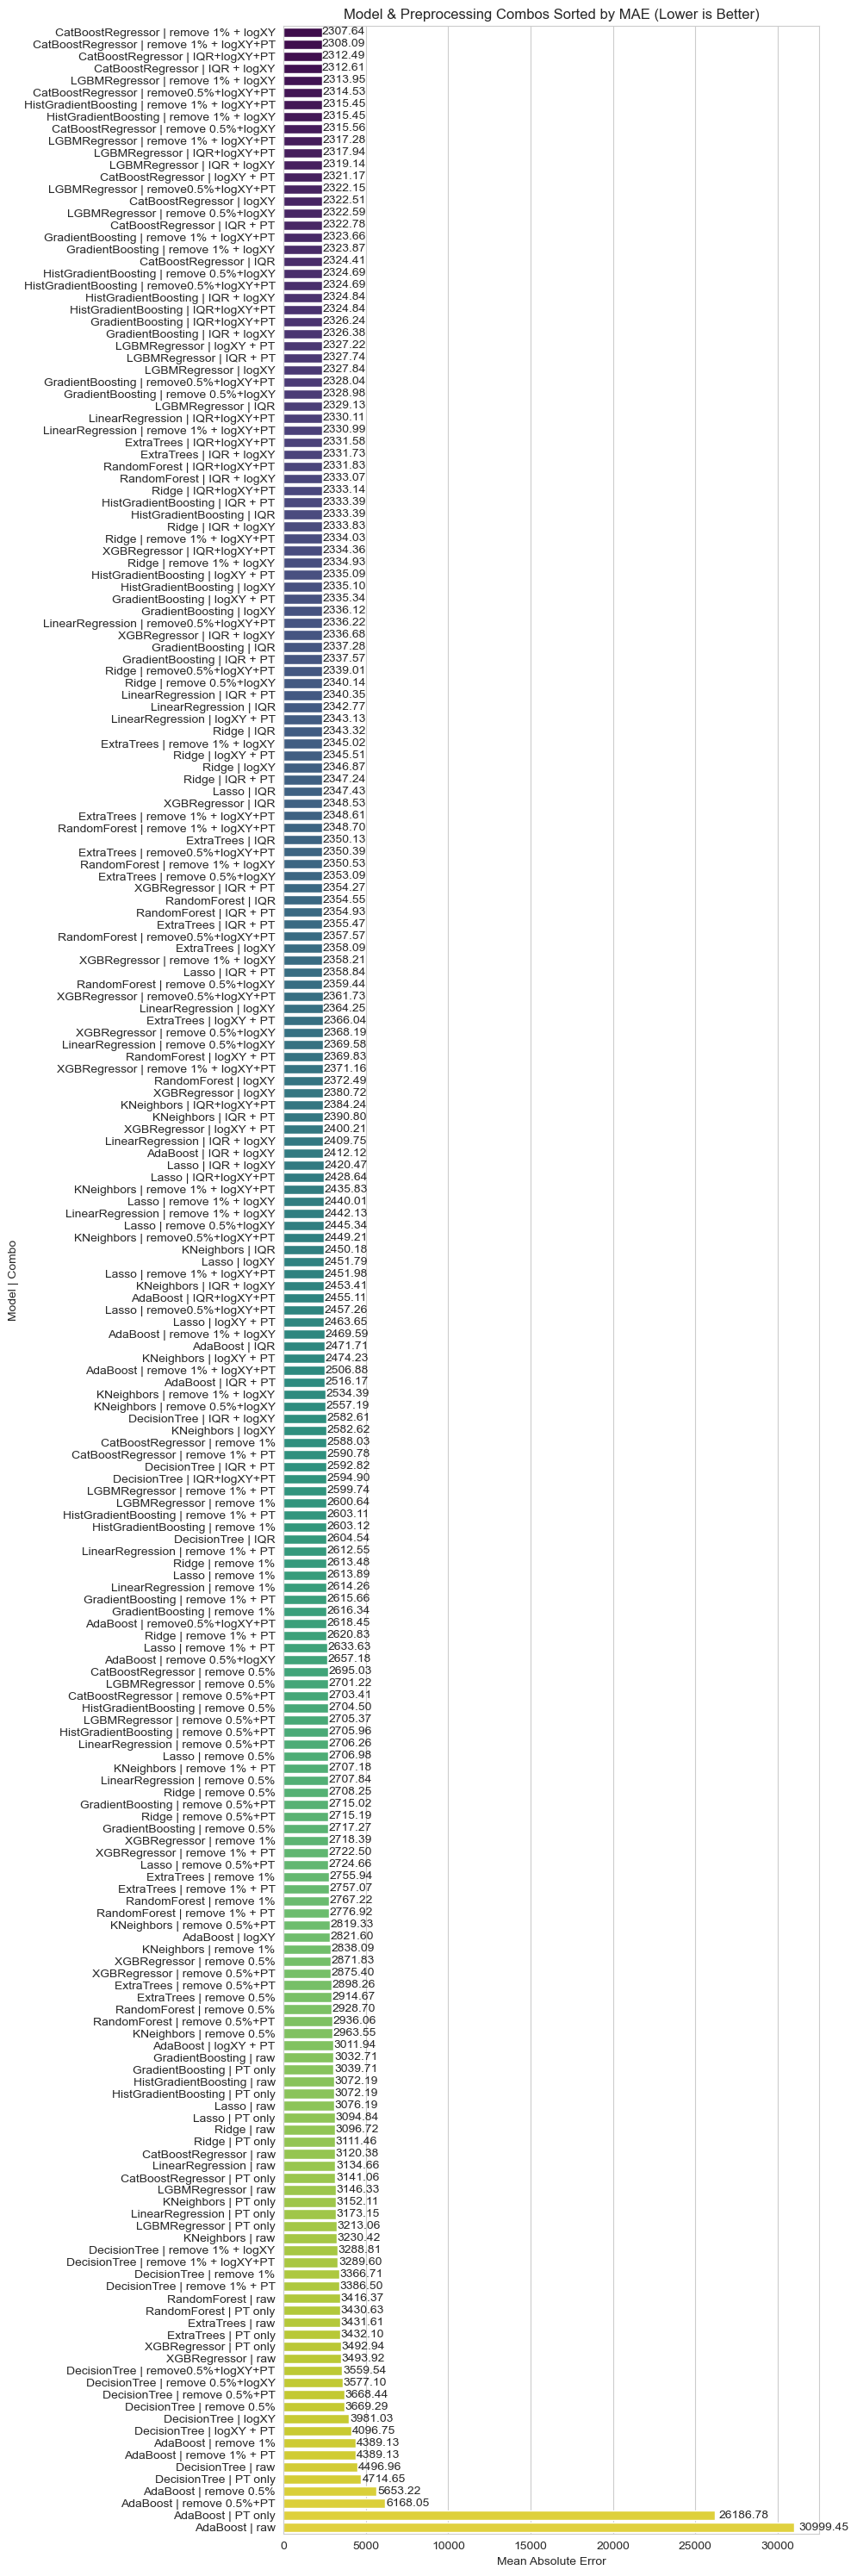

In [87]:
# 6) 시각화
plt.figure(figsize=(10, 30))
ax = sns.barplot(
    x='MAE',
    y=df['model'] + ' | ' + df['combo'],
    data=df,
    palette='viridis'
)
plt.title('Model & Preprocessing Combos Sorted by MAE (Lower is Better)')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model | Combo')

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + 0.01 * width, y, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

---

### 전처리

In [101]:
from sklearn.model_selection import PredefinedSplit

# 1) train+valid 합치기
train_flag = np.concatenate([
    np.ones(len(X_train), dtype=bool),   # True = train
    np.zeros(len(X_valid), dtype=bool)   # False = valid
])
X_tv = pd.concat([X_train, X_valid], axis=0)
y_tv = pd.concat([y_train, y_valid], axis=0)

# 2) 이상치 제거 + 로그 변환 (remove_pct=0.99)
thresh = np.percentile(y_tv, 0.99*100)
mask   = y_tv <= thresh

X_tv_proc = X_tv.loc[mask].copy()
y_tv_proc = y_tv.loc[mask].copy()

y_tv_proc = np.log1p(y_tv_proc)
skew_cols = X_tv_proc.columns[
    (X_tv_proc.skew().abs() > 1) &
    (X_tv_proc.min()    >= 0)
]
X_tv_proc[skew_cols] = np.log1p(X_tv_proc[skew_cols])

# 3) train_flag 에도 같은 마스크 적용
train_flag_proc = train_flag[mask.values]

# 4) PredefinedSplit 생성
test_fold = np.where(train_flag_proc, -1, 0)
ps = PredefinedSplit(test_fold=test_fold)

# 5) test 세트에도 same 로그 변환
X_test_proc = X_test.copy()
X_test_proc[skew_cols] = np.log1p(X_test_proc[skew_cols])

### 하이퍼파라미터 튜닝

In [102]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import optuna
from sklearn.pipeline import Pipeline

# Optuna용 objective factory
def make_objective(model_name):
    def objective(trial):
        # PT 적용 여부도 하이퍼파라미터로 제안
        use_pt = trial.suggest_categorical('use_pt', [False, True])
        pt = PowerTransformer(method='yeo-johnson')

        # 모델별 하이퍼파라미터 설정
        if model_name == 'Cat':
            params = {
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 9, step=2),
                'iterations': trial.suggest_categorical('iterations', [200, 500, 800]),
                'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
                'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
                'random_state': 42, 'verbose': False
            }
            model = CatBoostRegressor(**params)

        elif model_name == 'LGBM':
            params = {
                'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
                'num_leaves': trial.suggest_categorical('num_leaves', [31, 63, 127]),
                'max_depth': trial.suggest_categorical('max_depth', [-1, 5, 10, 15]),
                'min_child_samples': trial.suggest_categorical('min_child_samples', [5, 10, 20]),
                'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
                'random_state': 42
            }
            model = LGBMRegressor(**params)

        elif model_name == 'HistGB':
            params = {
                'max_iter': trial.suggest_categorical('max_iter', [100, 200, 300]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
                'max_depth': trial.suggest_categorical('max_depth', [None, 5, 10]),
                'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 3, 5]),
                'l2_regularization': trial.suggest_categorical('l2_regularization', [0.0, 0.1, 0.5])
            }
            model = HistGradientBoostingRegressor(**params, random_state=42)

        else:  # GB
            params = {
                'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
                'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7]),
                'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
                'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
                'random_state': 42
            }
            model = GradientBoostingRegressor(**params)

        preds = np.zeros(len(y_tv_proc))

        # PredefinedSplit을 사용한 단일 fold
        for train_idx, valid_idx in ps.split():
            X_tr, y_tr = X_tv_proc.iloc[train_idx], y_tv_proc.iloc[train_idx]
            X_va, y_va = X_tv_proc.iloc[valid_idx], y_tv_proc.iloc[valid_idx]

            # PT 적용 시 학습/검증 데이터 변환
            if use_pt:
                X_tr_trans = pt.fit_transform(X_tr)
                X_va_trans = pt.transform(X_va)
            else:
                X_tr_trans, X_va_trans = X_tr, X_va

            # 모델 학습
            if model_name == 'Cat':
                model.fit(
                    X_tr_trans, y_tr,
                    eval_set=(X_va_trans, y_va),
                    use_best_model=True
                )
            elif model_name == 'LGBM':
                model.fit(
                    X_tr_trans, y_tr,
                    eval_set=[(X_va_trans, y_va)]
                )
            else:
                model.fit(X_tr_trans, y_tr)

            # 검증 예측
            preds[valid_idx] = model.predict(X_va_trans)

        # valid 인덱스 부분만 MAE 계산
        return mean_absolute_error(y_tv_proc[test_fold == 0], preds[test_fold == 0])

    return objective

# 모델별 Optuna 최적화 + 재학습
best_estimators = {}
studies = {}

for name in tqdm(['Cat', 'LGBM', 'HistGB', 'GB'], desc="Optuna tuning"):
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(make_objective(name), n_trials=50, show_progress_bar=True)
    studies[name] = study
    print(f"{name} best params:", study.best_params)

    # ── 재학습 파트 ──
    # 1) best_params 복사
    params = study.best_params.copy()
    # 2) use_pt만 꺼내고 모델 파라미터에서 제거
    use_pt = params.pop('use_pt')
    # 3) 각 모델 인스턴스 생성
    if name == 'Cat':
        base = CatBoostRegressor(random_state=42, verbose=False, **params)
    elif name == 'LGBM':
        base = LGBMRegressor(random_state=42, **params)
    elif name == 'HistGB':
        base = HistGradientBoostingRegressor(random_state=42, **params)
    else:
        base = GradientBoostingRegressor(random_state=42, **params)

    # 4) use_pt 여부에 따라 Pipeline 구성
    if use_pt:
        pipe = Pipeline([('pt', PowerTransformer(method='yeo-johnson')), ('model', base)])
    else:
        pipe = Pipeline([('model', base)])

    # 5) TV 전체 데이터로 재학습
    pipe.fit(X_tv_proc, y_tv_proc)
    best_estimators[name] = pipe

# Test MAE/MSE 비교
results = []
for name, mdl in best_estimators.items():
    y_pred = np.expm1(mdl.predict(X_test_proc))
    results.append({
        'model': name,
        'test_MAE': mean_absolute_error(y_test, y_pred),
        'test_MSE': mean_squared_error(y_test, y_pred)
    })
df_test = pd.DataFrame(results).set_index('model').sort_values('test_MAE')

Optuna tuning:   0%|          | 0/4 [00:00<?, ?it/s][I 2025-05-08 15:55:38,001] A new study created in memory with name: no-name-5e210511-60cd-4804-8d02-cc841b908ad7


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
Optuna tuning:   0%|          | 0/4 [00:01<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[I 2025-05-08 15:55:39,001] Trial 0 finished with value: 0.5892213261407807 and parameters: {'use_pt': False, 'depth': 5, 'learning_rate': 0.01978710640673541, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.35246030467900136}. Best is trial 0 with value: 0.5892213261407807.


Optuna tuning:   0%|          | 0/4 [00:02<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:40,420] Trial 1 finished with value: 0.5926803171755387 and parameters: {'use_pt': False, 'depth': 8, 'learning_rate': 0.010728924190129269, 'l2_leaf_reg': 1, 'iterations': 500, 'border_count': 128, 'bagging_temperature': 0.7620921130334893}. Best is trial 0 with value: 0.5892213261407807.


Optuna tuning:   0%|          | 0/4 [00:03<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:41,366] Trial 2 finished with value: 0.5977853844127937 and parameters: {'use_pt': False, 'depth': 5, 'learning_rate': 0.006928816197129479, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.8518584162942296}. Best is trial 0 with value: 0.5892213261407807.


Optuna tuning:   0%|          | 0/4 [00:03<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:41,959] Trial 3 finished with value: 0.5865781825202511 and parameters: {'use_pt': False, 'depth': 5, 'learning_rate': 0.06868004319230822, 'l2_leaf_reg': 7, 'iterations': 500, 'border_count': 32, 'bagging_temperature': 0.18629812020174297}. Best is trial 3 with value: 0.5865781825202511.


Optuna tuning:   0%|          | 0/4 [00:05<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:43,849] Trial 4 finished with value: 0.5895724551496103 and parameters: {'use_pt': False, 'depth': 9, 'learning_rate': 0.015017056232505899, 'l2_leaf_reg': 7, 'iterations': 500, 'border_count': 128, 'bagging_temperature': 0.4554638640929827}. Best is trial 3 with value: 0.5865781825202511.


Optuna tuning:   0%|          | 0/4 [00:06<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:44,681] Trial 5 finished with value: 0.5902832829095964 and parameters: {'use_pt': False, 'depth': 4, 'learning_rate': 0.02163860234985918, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.23498836159081438}. Best is trial 3 with value: 0.5865781825202511.


Optuna tuning:   0%|          | 0/4 [00:09<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:47,045] Trial 6 finished with value: 0.584092808409439 and parameters: {'use_pt': False, 'depth': 9, 'learning_rate': 0.027127037381663388, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.15828337870431175}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:11<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:49,464] Trial 7 finished with value: 0.5863816085530364 and parameters: {'use_pt': True, 'depth': 9, 'learning_rate': 0.03618435690876316, 'l2_leaf_reg': 9, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.11006882102730509}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:12<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:50,434] Trial 8 finished with value: 0.5872676158201832 and parameters: {'use_pt': True, 'depth': 5, 'learning_rate': 0.09275322179603106, 'l2_leaf_reg': 1, 'iterations': 500, 'border_count': 32, 'bagging_temperature': 0.8648354067946724}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:13<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:51,893] Trial 9 finished with value: 0.5859629243121164 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.05001637778177146, 'l2_leaf_reg': 9, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.6128537635507474}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:15<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:53,189] Trial 10 finished with value: 0.5895315791069737 and parameters: {'use_pt': True, 'depth': 10, 'learning_rate': 0.03288884219819465, 'l2_leaf_reg': 5, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.007324453206623116}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:16<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:54,825] Trial 11 finished with value: 0.584589039837805 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.044821771492032446, 'l2_leaf_reg': 9, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.6399666877449496}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:17<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:55,516] Trial 12 finished with value: 0.5916533293087893 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.0395929960319767, 'l2_leaf_reg': 9, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.6407331304310111}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:19<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:57,198] Trial 13 finished with value: 0.585057654122427 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.027385460951150634, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.9883906628748929}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:20<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:55:58,961] Trial 14 finished with value: 0.5862394948206161 and parameters: {'use_pt': False, 'depth': 8, 'learning_rate': 0.059046610152181066, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.4020857111046613}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:24<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:02,808] Trial 15 finished with value: 0.5866321671787427 and parameters: {'use_pt': True, 'depth': 10, 'learning_rate': 0.013038310432001519, 'l2_leaf_reg': 9, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.568109089938005}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:25<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:03,598] Trial 16 finished with value: 0.6212262129028887 and parameters: {'use_pt': True, 'depth': 8, 'learning_rate': 0.005012790170430679, 'l2_leaf_reg': 7, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.30025306783314243}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:27<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:05,833] Trial 17 finished with value: 0.5867625445281025 and parameters: {'use_pt': False, 'depth': 9, 'learning_rate': 0.0919750744988346, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.7142528374143157}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:29<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:07,288] Trial 18 finished with value: 0.5846095176790151 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.04736515905552337, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.5015688689170825}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:29<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:07,685] Trial 19 finished with value: 0.5946504461545654 and parameters: {'use_pt': False, 'depth': 7, 'learning_rate': 0.026391473273573815, 'l2_leaf_reg': 9, 'iterations': 200, 'border_count': 128, 'bagging_temperature': 0.030492312991622805}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:31<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:09,282] Trial 20 finished with value: 0.5851098433650133 and parameters: {'use_pt': False, 'depth': 8, 'learning_rate': 0.019407123341163804, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.528862535336357}. Best is trial 6 with value: 0.584092808409439.


Optuna tuning:   0%|          | 0/4 [00:32<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:10,738] Trial 21 finished with value: 0.5839554442897161 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.04665330906000037, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.481288613144079}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:34<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:12,144] Trial 22 finished with value: 0.5845203134826714 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.0673783090353221, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.7251992289488594}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:35<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:13,599] Trial 23 finished with value: 0.5841788324708438 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.0661776289479816, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.7615138795835874}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:37<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:15,115] Trial 24 finished with value: 0.5854924077899059 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.07483679358070076, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.9506546577461198}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:38<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:16,314] Trial 25 finished with value: 0.5880022210202144 and parameters: {'use_pt': True, 'depth': 4, 'learning_rate': 0.030911975568430575, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.15848443195814227}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:39<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:17,839] Trial 26 finished with value: 0.5844709041174494 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.055968698249931614, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.4197386665518074}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:41<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:19,321] Trial 27 finished with value: 0.584424372631179 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.03890852378356398, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.28690843798647725}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:41<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:19,753] Trial 28 finished with value: 0.5893658572281422 and parameters: {'use_pt': False, 'depth': 5, 'learning_rate': 0.07775268433469892, 'l2_leaf_reg': 5, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.816638427515179}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:42<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:20,736] Trial 29 finished with value: 0.5895819288857577 and parameters: {'use_pt': False, 'depth': 7, 'learning_rate': 0.01811224916773528, 'l2_leaf_reg': 5, 'iterations': 500, 'border_count': 64, 'bagging_temperature': 0.3363629484767502}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:44<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:22,020] Trial 30 finished with value: 0.5878872818824735 and parameters: {'use_pt': True, 'depth': 4, 'learning_rate': 0.026427937053814698, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.3834907991081412}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:45<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:23,539] Trial 31 finished with value: 0.5850288305180372 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.039245240217998, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.3001260871092042}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:47<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:25,035] Trial 32 finished with value: 0.5847830575894503 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.057887264632866316, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.25757669420009577}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:48<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:26,350] Trial 33 finished with value: 0.586102403072364 and parameters: {'use_pt': True, 'depth': 5, 'learning_rate': 0.04342404722106307, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.10764408424374933}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:50<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:28,036] Trial 34 finished with value: 0.5845211298782017 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.029168711164320953, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.21145059258508225}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:50<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:28,638] Trial 35 finished with value: 0.5862202470439045 and parameters: {'use_pt': False, 'depth': 5, 'learning_rate': 0.053501403185976154, 'l2_leaf_reg': 1, 'iterations': 500, 'border_count': 64, 'bagging_temperature': 0.47160434816388463}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:52<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:30,622] Trial 36 finished with value: 0.5899927805003455 and parameters: {'use_pt': False, 'depth': 8, 'learning_rate': 0.009499096812856381, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.12143214132299693}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:54<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:32,074] Trial 37 finished with value: 0.5878913983230292 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.01638598052135043, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.06522517469277406}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:55<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:33,262] Trial 38 finished with value: 0.5867514027572962 and parameters: {'use_pt': False, 'depth': 9, 'learning_rate': 0.02283929608193341, 'l2_leaf_reg': 1, 'iterations': 500, 'border_count': 32, 'bagging_temperature': 0.2644118598010855}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:56<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:34,504] Trial 39 finished with value: 0.5878201940702111 and parameters: {'use_pt': True, 'depth': 5, 'learning_rate': 0.02364169097775307, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.18402357863059515}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:57<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:35,883] Trial 40 finished with value: 0.5866229503685648 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.03425363203188635, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.3448698697170338}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [00:59<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:37,397] Trial 41 finished with value: 0.5851971232255334 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.06600722389468862, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.4164905525250074}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:00<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:38,902] Trial 42 finished with value: 0.5842926638838192 and parameters: {'use_pt': True, 'depth': 6, 'learning_rate': 0.05224777887732213, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.4491633711149844}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:02<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:40,241] Trial 43 finished with value: 0.5855856074614086 and parameters: {'use_pt': True, 'depth': 5, 'learning_rate': 0.03944200064311631, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.5448812602115823}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:04<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:42,058] Trial 44 finished with value: 0.5843873028097939 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.08421740600544675, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.4583944994461944}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:05<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:43,325] Trial 45 finished with value: 0.5852338169277012 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.08370070649429534, 'l2_leaf_reg': 5, 'iterations': 500, 'border_count': 128, 'bagging_temperature': 0.577903551955327}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:07<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:45,248] Trial 46 finished with value: 0.5841124054006785 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.0973273831783387, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.46488148206437235}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:08<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:46,485] Trial 47 finished with value: 0.5862627367003647 and parameters: {'use_pt': False, 'depth': 10, 'learning_rate': 0.09913674048670307, 'l2_leaf_reg': 3, 'iterations': 200, 'border_count': 128, 'bagging_temperature': 0.6899990194050946}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:10<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-08 15:56:48,893] Trial 48 finished with value: 0.5847853102716297 and parameters: {'use_pt': True, 'depth': 8, 'learning_rate': 0.06631119180211013, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.7730927428993835}. Best is trial 21 with value: 0.5839554442897161.


Optuna tuning:   0%|          | 0/4 [01:12<?, ?it/s]

[I 2025-05-08 15:56:50,842] Trial 49 finished with value: 0.5842033348464504 and parameters: {'use_pt': True, 'depth': 7, 'learning_rate': 0.05018393966145884, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.6168570305857161}. Best is trial 21 with value: 0.5839554442897161.
Cat best params: {'use_pt': True, 'depth': 6, 'learning_rate': 0.04665330906000037, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.481288613144079}


Optuna tuning:  25%|██▌       | 1/4 [01:14<03:43, 74.63s/it][I 2025-05-08 15:56:52,627] A new study created in memory with name: no-name-8cbe6909-1e98-4865-81dc-743a9a797d5b


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:15<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:56:53,111] Trial 0 finished with value: 0.5950402537314674 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.03160641798334919, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.5950402537314674.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:16<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:56:54,604] Trial 1 finished with value: 0.5867386848357231 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.03138211223152721, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:19<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:56:57,210] Trial 2 finished with value: 0.6108337594184403 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.005320758006571377, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 5, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

Optuna tuning:  25%|██▌       | 1/4 [01:19<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:20<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [01:22<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:00,456] Trial 5 finished with value: 0.5988176278193286 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.006658952763370211, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:23<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:01,980] Trial 6 finished with value: 0.6092502592394109 and parameters: {'use_pt': True, 'n_estimators': 100, 'learning_rate': 0.011210776900886862, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:25<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:03,209] Trial 7 finished with value: 0.5944961571823314 and parameters: {'use_pt': False, 'n_estimators': 200, 'learning_rate': 0.012658043869209809, 'num_leaves': 63, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:26<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:04,373] Trial 8 finished with value: 0.6031955966920393 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.009312906706258272, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:28<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:06,078] Trial 9 finished with value: 0.605364307901738 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.007162708275839303, 'num_leaves': 63, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:29<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:07,466] Trial 10 finished with value: 0.5886432975904228 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.020188377312891546, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:30<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:08,753] Trial 11 finished with value: 0.5868402680264652 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.047329822813462666, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:32<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:10,036] Trial 12 finished with value: 0.587303609587514 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.04824403095636801, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:33<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:11,407] Trial 13 finished with value: 0.5875928467012683 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.04384780443206043, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:34<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:12,717] Trial 14 finished with value: 0.586830180969852 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.02983864764936705, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:36<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:14,150] Trial 15 finished with value: 0.588592593065405 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.01836829028585007, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.5867386848357231.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:37<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:15,503] Trial 16 finished with value: 0.586527111012942 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.028909500898655873, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 16 with value: 0.586527111012942.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [01:40<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-08 15:57:18,780] Trial 17 finished with value: 0.5851172708593788 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.025471937289010715, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 17 with value: 0.5851172708593788.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Optuna tuning:  25%|██▌       | 1/4 [01:44<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-08 15:57:22,082] Trial 18 finished with value: 0.5851202241974536 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.023920220454754844, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 17 with value: 0.5851172708593788.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[Light

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [01:47<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:25,498] Trial 19 finished with value: 0.5859578651824651 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.015455750049015582, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 17 with value: 0.5851172708593788.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Optuna tuning:  25%|██▌       | 1/4 [01:47<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [01:50<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:28,085] Trial 21 finished with value: 0.5860759571934872 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.015338148680170317, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 17 with value: 0.5851172708593788.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:51<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:29,977] Trial 22 finished with value: 0.5875360712201674 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.016088182620550003, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 17 with value: 0.5851172708593788.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:53<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:31,796] Trial 23 finished with value: 0.5845460337313806 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.02389864033061687, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 23 with value: 0.5845460337313806.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:55<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:33,728] Trial 24 finished with value: 0.5843459980646161 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.023801151208244435, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:57<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:35,799] Trial 25 finished with value: 0.5843615444769515 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.036496223735681066, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [01:59<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:37,573] Trial 26 finished with value: 0.5855838675822748 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.038806415879144344, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:01<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:39,667] Trial 27 finished with value: 0.5855775351742939 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03571256365038229, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:02<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:40,420] Trial 28 finished with value: 0.596627613198029 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.019629682909946804, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:04<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:42,126] Trial 29 finished with value: 0.5856756529356475 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03848185209223903, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:04<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:42,887] Trial 30 finished with value: 0.5914779272150009 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.026595008161787826, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:06<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:44,651] Trial 31 finished with value: 0.5850509871954767 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.02474474408079505, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:08<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:46,648] Trial 32 finished with value: 0.5855573026623331 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03409061065451526, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:10<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:48,516] Trial 33 finished with value: 0.5864004124697597 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.02130269024732034, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:12<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:50,402] Trial 34 finished with value: 0.5865136985864068 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.027550064453834053, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:14<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:52,306] Trial 35 finished with value: 0.5874088591577731 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.016979555584457132, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Optuna tuning:  25%|██▌       | 1/4 [02:14<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [02:16<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:54,869] Trial 37 finished with value: 0.5875447914009585 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.01291797557931202, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:17<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:55,478] Trial 38 finished with value: 0.5966969141301776 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.02246521630272326, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 5, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:19<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:57,485] Trial 39 finished with value: 0.5863160478493311 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.042315539619736, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

Optuna tuning:  25%|██▌       | 1/4 [02:19<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-08 15:57:57,900] Trial 40 finished with value: 0.5892514556602862 and parameters: {'use_pt': False, 'n_estimators': 200, 'learning_rate': 0.03408940534956211, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [02:21<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:57:59,756] Trial 41 finished with value: 0.5854367529324089 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.026247699328203426, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 5, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:23<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:58:01,599] Trial 42 finished with value: 0.5854462506772363 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.02444845024198771, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [02:25<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:58:03,126] Trial 43 finished with value: 0.5869207474110799 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.018004320803106964, 'num_leaves': 63, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:27<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:58:05,066] Trial 44 finished with value: 0.5853434180253096 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.02573935703707064, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 5, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [02:29<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:58:07,408] Trial 45 finished with value: 0.5857865520530893 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.020746196453389546, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:30<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-08 15:58:08,730] Trial 46 finished with value: 0.5875423241069663 and parameters: {'use_pt': False, 'n_estimators': 200, 'learning_rate': 0.030515993729451203, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 24 with value: 0.5843459980646161.


/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [02:31<03:43, 74.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [02:33<03:43, 74.63s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-08 15:58:11,420] Trial 48 finished with value: 0.5866622294063976 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.01313993273484669, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8446
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Info] Start training from score 7.443191


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Optuna tuning:  25%|██▌       | 1/4 [02:36<03:43, 74.63s/it]

[I 2025-05-08 15:58:14,127] Trial 49 finished with value: 0.6002812595240131 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.005403499598713675, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 24 with value: 0.5843459980646161.
LGBM best params: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.023801151208244435, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 

Optuna tuning:  50%|█████     | 2/4 [02:38<02:40, 80.04s/it][I 2025-05-08 15:58:16,454] A new study created in memory with name: no-name-9ceef922-cb9b-4193-8779-cd2aff7e8cdb


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
Optuna tuning:  50%|█████     | 2/4 [02:39<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:17,115] Trial 0 finished with value: 0.5963341090410084 and parameters: {'use_pt': False, 'max_iter': 100, 'learning_rate': 0.02863192150913184, 'max_depth': None, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 0 with value: 0.5963341090410084.


Optuna tuning:  50%|█████     | 2/4 [02:40<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:18,370] Trial 1 finished with value: 0.5933372126472616 and parameters: {'use_pt': False, 'max_iter': 200, 'learning_rate': 0.017053260069948672, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 1 with value: 0.5933372126472616.


Optuna tuning:  50%|█████     | 2/4 [02:42<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:20,654] Trial 2 finished with value: 0.5921033733857118 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.012744618530135102, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 2 with value: 0.5921033733857118.


Optuna tuning:  50%|█████     | 2/4 [02:43<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:21,686] Trial 3 finished with value: 0.6071112120801249 and parameters: {'use_pt': True, 'max_iter': 100, 'learning_rate': 0.015605944708158096, 'max_depth': 10, 'min_samples_leaf': 3, 'l2_regularization': 0.5}. Best is trial 2 with value: 0.5921033733857118.


Optuna tuning:  50%|█████     | 2/4 [02:44<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:22,919] Trial 4 finished with value: 0.590548125936607 and parameters: {'use_pt': False, 'max_iter': 300, 'learning_rate': 0.030481895686004158, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 4 with value: 0.590548125936607.


Optuna tuning:  50%|█████     | 2/4 [02:45<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:23,929] Trial 5 finished with value: 0.5978059641052761 and parameters: {'use_pt': True, 'max_iter': 100, 'learning_rate': 0.025186665954099213, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 4 with value: 0.590548125936607.


Optuna tuning:  50%|█████     | 2/4 [02:46<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:24,840] Trial 6 finished with value: 0.5927141479825847 and parameters: {'use_pt': False, 'max_iter': 200, 'learning_rate': 0.02164390442728559, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 4 with value: 0.590548125936607.


Optuna tuning:  50%|█████     | 2/4 [02:48<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:26,287] Trial 7 finished with value: 0.5920285981545599 and parameters: {'use_pt': False, 'max_iter': 200, 'learning_rate': 0.019648449748471967, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.5}. Best is trial 4 with value: 0.590548125936607.


Optuna tuning:  50%|█████     | 2/4 [02:49<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:27,624] Trial 8 finished with value: 0.5891234800533333 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.040928610836872846, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 8 with value: 0.5891234800533333.


Optuna tuning:  50%|█████     | 2/4 [02:50<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:28,277] Trial 9 finished with value: 0.5991973924457156 and parameters: {'use_pt': False, 'max_iter': 100, 'learning_rate': 0.022665534979348912, 'max_depth': None, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 8 with value: 0.5891234800533333.


Optuna tuning:  50%|█████     | 2/4 [02:51<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:29,251] Trial 10 finished with value: 0.5886846433139262 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04708600352022606, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:52<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:30,222] Trial 11 finished with value: 0.58920589160154 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04880036627682637, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:53<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:31,293] Trial 12 finished with value: 0.5893803786460127 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.0494320727261901, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:54<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:32,574] Trial 13 finished with value: 0.5903780596791063 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03720146165535256, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:55<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:33,776] Trial 14 finished with value: 0.5899453737102527 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.0380570818747641, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:57<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:35,246] Trial 15 finished with value: 0.5897661629054898 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.038190254850539694, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:58<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:36,277] Trial 16 finished with value: 0.590383532158453 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04268573886001113, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [02:59<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:37,503] Trial 17 finished with value: 0.5895602722787542 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03193654135131698, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [03:01<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:39,860] Trial 18 finished with value: 0.5941080876074557 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.010879782498487775, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [03:02<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:40,710] Trial 19 finished with value: 0.5915971124566964 and parameters: {'use_pt': True, 'max_iter': 200, 'learning_rate': 0.043600250200172525, 'max_depth': 5, 'min_samples_leaf': 3, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [03:04<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:42,206] Trial 20 finished with value: 0.5895448401323975 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03450929038500235, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [03:05<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:43,067] Trial 21 finished with value: 0.5901514767784397 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04955907305118034, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [03:06<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:44,037] Trial 22 finished with value: 0.5900393179881793 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04286999254874797, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 10 with value: 0.5886846433139262.


Optuna tuning:  50%|█████     | 2/4 [03:07<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:45,046] Trial 23 finished with value: 0.5886416928416232 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04856466488502107, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:08<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:46,591] Trial 24 finished with value: 0.5893725721962991 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.027039300836811973, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:09<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:47,580] Trial 25 finished with value: 0.5905886572464506 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04287982893742051, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:11<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:49,251] Trial 26 finished with value: 0.5898852390570694 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.034252710120693274, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:12<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:50,433] Trial 27 finished with value: 0.5888978176728148 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.039517979418879176, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:13<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:51,669] Trial 28 finished with value: 0.5897930398208246 and parameters: {'use_pt': True, 'max_iter': 200, 'learning_rate': 0.046171403834881976, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:14<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:52,226] Trial 29 finished with value: 0.598774872861347 and parameters: {'use_pt': False, 'max_iter': 100, 'learning_rate': 0.027424082263557557, 'max_depth': 5, 'min_samples_leaf': 3, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:15<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:53,188] Trial 30 finished with value: 0.5958423246487666 and parameters: {'use_pt': True, 'max_iter': 100, 'learning_rate': 0.03419790826704587, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:16<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:54,524] Trial 31 finished with value: 0.5896559436370408 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.0398206003474063, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:17<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:55,851] Trial 32 finished with value: 0.5897606406182911 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03913917548431546, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:19<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:57,297] Trial 33 finished with value: 0.5903968148967345 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.045967220187345795, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:20<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:58:58,971] Trial 34 finished with value: 0.5894940561976219 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04153495865983665, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:22<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:00,529] Trial 35 finished with value: 0.5899121727423884 and parameters: {'use_pt': False, 'max_iter': 300, 'learning_rate': 0.030916614587082312, 'max_depth': None, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:23<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:01,883] Trial 36 finished with value: 0.5890210098479783 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.035455264114336554, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:25<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:03,122] Trial 37 finished with value: 0.5974681665221998 and parameters: {'use_pt': True, 'max_iter': 200, 'learning_rate': 0.014999885033856134, 'max_depth': 5, 'min_samples_leaf': 3, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:25<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:03,793] Trial 38 finished with value: 0.6006547341390893 and parameters: {'use_pt': False, 'max_iter': 100, 'learning_rate': 0.024609138523653463, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:26<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:04,983] Trial 39 finished with value: 0.5889636843377761 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03617146337508703, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:28<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:06,577] Trial 40 finished with value: 0.5897774384656221 and parameters: {'use_pt': False, 'max_iter': 200, 'learning_rate': 0.03045098311411189, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:29<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:07,919] Trial 41 finished with value: 0.5895928012147921 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04599653533549783, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:31<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:09,426] Trial 42 finished with value: 0.5895052572935596 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03553634445532516, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:33<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:11,116] Trial 43 finished with value: 0.5905373881123805 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.018550516156185703, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:34<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:12,113] Trial 44 finished with value: 0.5894842674530113 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.045887121606116035, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:35<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:13,471] Trial 45 finished with value: 0.5898482579480292 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.03214400311531503, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:36<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:14,752] Trial 46 finished with value: 0.5890554194862193 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.035912353326146444, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:38<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:16,005] Trial 47 finished with value: 0.5959352384166764 and parameters: {'use_pt': True, 'max_iter': 100, 'learning_rate': 0.02886369599631964, 'max_depth': None, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:38<02:40, 80.04s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:16,994] Trial 48 finished with value: 0.5891734423588687 and parameters: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.049712462675549074, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 23 with value: 0.5886416928416232.


Optuna tuning:  50%|█████     | 2/4 [03:40<02:40, 80.04s/it]

[I 2025-05-08 15:59:18,179] Trial 49 finished with value: 0.5891674730151805 and parameters: {'use_pt': False, 'max_iter': 300, 'learning_rate': 0.03997528959693011, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 23 with value: 0.5886416928416232.
HistGB best params: {'use_pt': True, 'max_iter': 300, 'learning_rate': 0.04856466488502107, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}


Optuna tuning:  75%|███████▌  | 3/4 [03:41<01:12, 72.09s/it][I 2025-05-08 15:59:19,095] A new study created in memory with name: no-name-41097fb7-833b-4847-bc1f-0a26d7cf1f2c


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
Optuna tuning:  75%|███████▌  | 3/4 [04:16<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 15:59:54,776] Trial 0 finished with value: 0.5912791504627877 and parameters: {'use_pt': False, 'n_estimators': 200, 'learning_rate': 0.019588313149959454, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 0 with value: 0.5912791504627877.


Optuna tuning:  75%|███████▌  | 3/4 [04:55<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:00:33,481] Trial 1 finished with value: 0.5878850831870023 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03749138209754896, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [05:18<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:00:56,991] Trial 2 finished with value: 0.5889861496466128 and parameters: {'use_pt': True, 'n_estimators': 100, 'learning_rate': 0.04891106841297758, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [06:16<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:01:54,879] Trial 3 finished with value: 0.599102575244804 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.010921981126625782, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 1.0}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [07:07<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:02:45,609] Trial 4 finished with value: 0.5911580956934168 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.016080831759220853, 'max_depth': 5, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [08:15<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:03:53,680] Trial 5 finished with value: 0.5904743183366941 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.011437217040879669, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [08:40<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:04:18,543] Trial 6 finished with value: 0.5915339253828626 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.024025510725272967, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [09:05<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:04:43,432] Trial 7 finished with value: 0.5905050932866752 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.029799576761407313, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [09:15<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:04:53,788] Trial 8 finished with value: 0.6074765813514749 and parameters: {'use_pt': True, 'n_estimators': 100, 'learning_rate': 0.02780681474550263, 'max_depth': 3, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [09:41<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:05:19,836] Trial 9 finished with value: 0.6005093180421553 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.02261288047674196, 'max_depth': 3, 'min_samples_split': 10, 'subsample': 1.0}. Best is trial 1 with value: 0.5878850831870023.


Optuna tuning:  75%|███████▌  | 3/4 [10:20<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:05:58,275] Trial 10 finished with value: 0.5868859884964728 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04434125150360064, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [10:57<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:06:35,348] Trial 11 finished with value: 0.5875096491158575 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04572970052316236, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [11:34<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:07:12,249] Trial 12 finished with value: 0.5876922199615461 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04932459813826271, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [12:10<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:07:48,940] Trial 13 finished with value: 0.5884495430058991 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03798613911702995, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [12:47<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:08:25,588] Trial 14 finished with value: 0.5882993413298355 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03758685432385681, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [13:24<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:09:02,347] Trial 15 finished with value: 0.5873658273950806 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.042809673585616985, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [13:36<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:09:14,811] Trial 16 finished with value: 0.605629376731489 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.03201669556778713, 'max_depth': 3, 'min_samples_split': 5, 'subsample': 1.0}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [14:14<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:09:52,024] Trial 17 finished with value: 0.5902854448489495 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.0174977415294863, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [14:53<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:10:31,291] Trial 18 finished with value: 0.5877563649877346 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04069455646518729, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [15:32<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:11:10,189] Trial 19 finished with value: 0.593310756419577 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03274604080146151, 'max_depth': 3, 'min_samples_split': 5, 'subsample': 1.0}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [15:44<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:11:22,831] Trial 20 finished with value: 0.5981899896431423 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.026581086455443936, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 10 with value: 0.5868859884964728.


Optuna tuning:  75%|███████▌  | 3/4 [16:23<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:12:01,049] Trial 21 finished with value: 0.5864030104262233 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.0468327359554778, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [17:00<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:12:38,978] Trial 22 finished with value: 0.5872362383243097 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04343174678849898, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [17:39<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:13:17,929] Trial 23 finished with value: 0.5891580134410095 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03425097074566434, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [18:18<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:13:56,206] Trial 24 finished with value: 0.5878428429482945 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04348455143708174, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [18:55<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:14:33,668] Trial 25 finished with value: 0.592294686974559 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.014240627460849644, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [19:33<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:15:11,380] Trial 26 finished with value: 0.5875440108958175 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.035911559082203476, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [20:11<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:15:49,014] Trial 27 finished with value: 0.5876979142812737 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04963088672246488, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [20:49<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:16:27,341] Trial 28 finished with value: 0.5925749289566585 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04125795582187153, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [21:12<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:16:50,020] Trial 29 finished with value: 0.593102535707213 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.026389479083623952, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [21:45<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:17:23,955] Trial 30 finished with value: 0.5881329908123731 and parameters: {'use_pt': False, 'n_estimators': 200, 'learning_rate': 0.030598504634542775, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 21 with value: 0.5864030104262233.


Optuna tuning:  75%|███████▌  | 3/4 [22:23<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:18:01,453] Trial 31 finished with value: 0.5863477424615859 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04422338030300638, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [23:00<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:18:38,909] Trial 32 finished with value: 0.5877909467979809 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.044972966355440486, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [23:38<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:19:16,136] Trial 33 finished with value: 0.5878077211510567 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04068873365387013, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [24:15<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:19:53,663] Trial 34 finished with value: 0.5880802320365164 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.0384376125641464, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [24:53<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:20:31,027] Trial 35 finished with value: 0.5875228670932587 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.0455744587816202, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [26:01<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:21:39,672] Trial 36 finished with value: 0.5885106374149726 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.049419509765047734, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [26:39<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:22:17,144] Trial 37 finished with value: 0.5887617157567056 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03431129475884489, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [27:04<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:22:42,394] Trial 38 finished with value: 0.5988109306761894 and parameters: {'use_pt': True, 'n_estimators': 200, 'learning_rate': 0.013088905882582224, 'max_depth': 5, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [27:26<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:23:04,909] Trial 39 finished with value: 0.5989066931054445 and parameters: {'use_pt': False, 'n_estimators': 100, 'learning_rate': 0.019419604180237724, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [28:30<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:24:08,161] Trial 40 finished with value: 0.5883703006776465 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.04618263281243396, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 1.0}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [29:07<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:24:45,534] Trial 41 finished with value: 0.586915142945694 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04202348494659654, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [29:46<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:25:24,553] Trial 42 finished with value: 0.5869971005617992 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03956199537565406, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [30:24<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:26:02,562] Trial 43 finished with value: 0.5869636243563985 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.03959349773134299, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [30:49<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:26:27,724] Trial 44 finished with value: 0.5894718871808994 and parameters: {'use_pt': False, 'n_estimators': 200, 'learning_rate': 0.03578589436354897, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [31:28<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:27:06,015] Trial 45 finished with value: 0.5876016809286952 and parameters: {'use_pt': True, 'n_estimators': 300, 'learning_rate': 0.04668851301349539, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [31:51<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:27:29,278] Trial 46 finished with value: 0.5928004770974934 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.029662749066898454, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [32:41<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:28:19,536] Trial 47 finished with value: 0.5865522318216534 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04245317575752848, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [33:33<01:12, 72.09s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3517598698.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-08 16:29:11,936] Trial 48 finished with value: 0.5872260866554242 and parameters: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.0367092830880844, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 31 with value: 0.5863477424615859.


Optuna tuning:  75%|███████▌  | 3/4 [33:51<01:12, 72.09s/it]

[I 2025-05-08 16:29:29,304] Trial 49 finished with value: 0.5928236155916452 and parameters: {'use_pt': True, 'n_estimators': 100, 'learning_rate': 0.04218593133154779, 'max_depth': 5, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 31 with value: 0.5863477424615859.
GB best params: {'use_pt': False, 'n_estimators': 300, 'learning_rate': 0.04422338030300638, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}


Optuna tuning: 100%|██████████| 4/4 [34:42<00:00, 520.57s/it]


/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


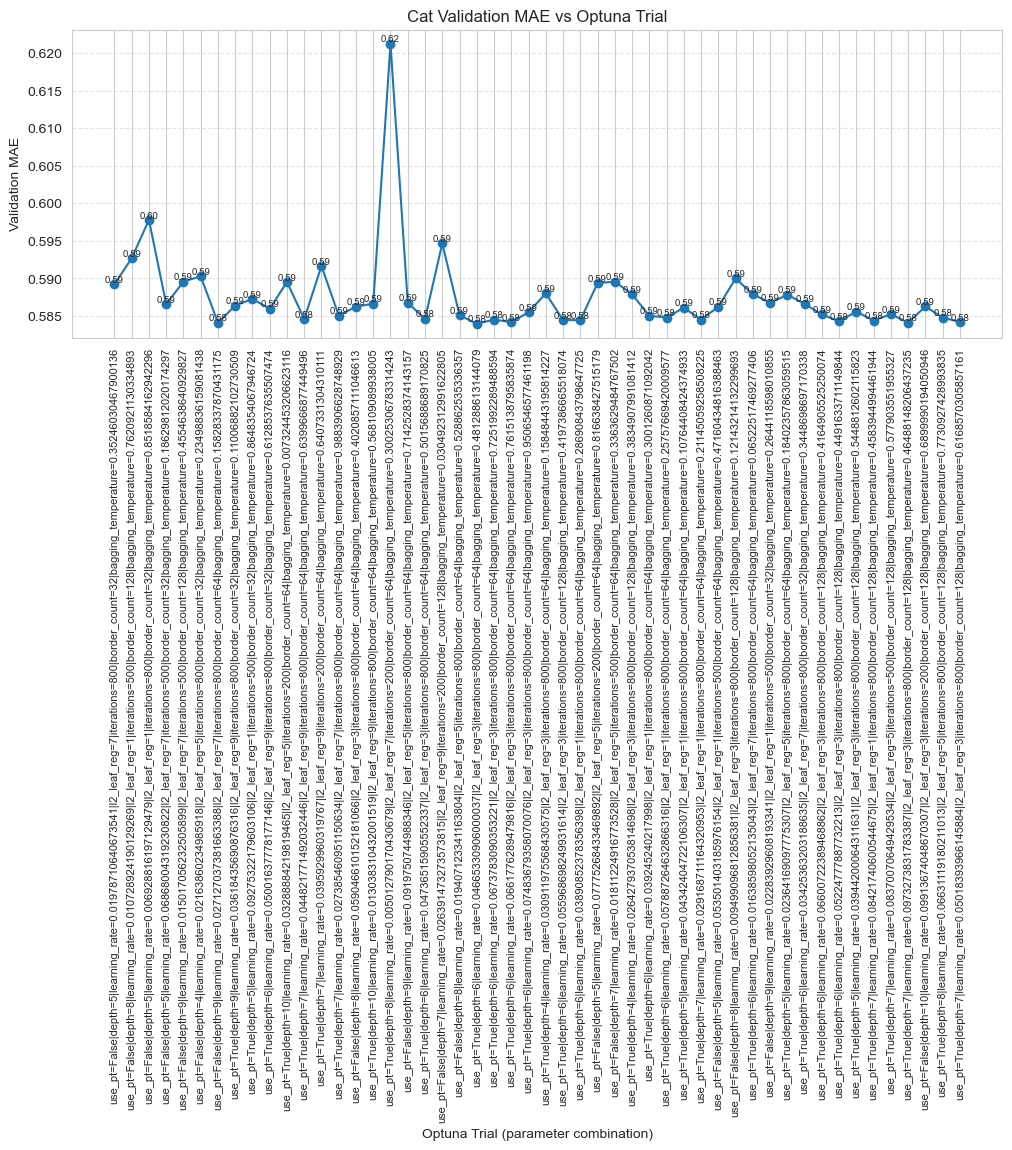

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


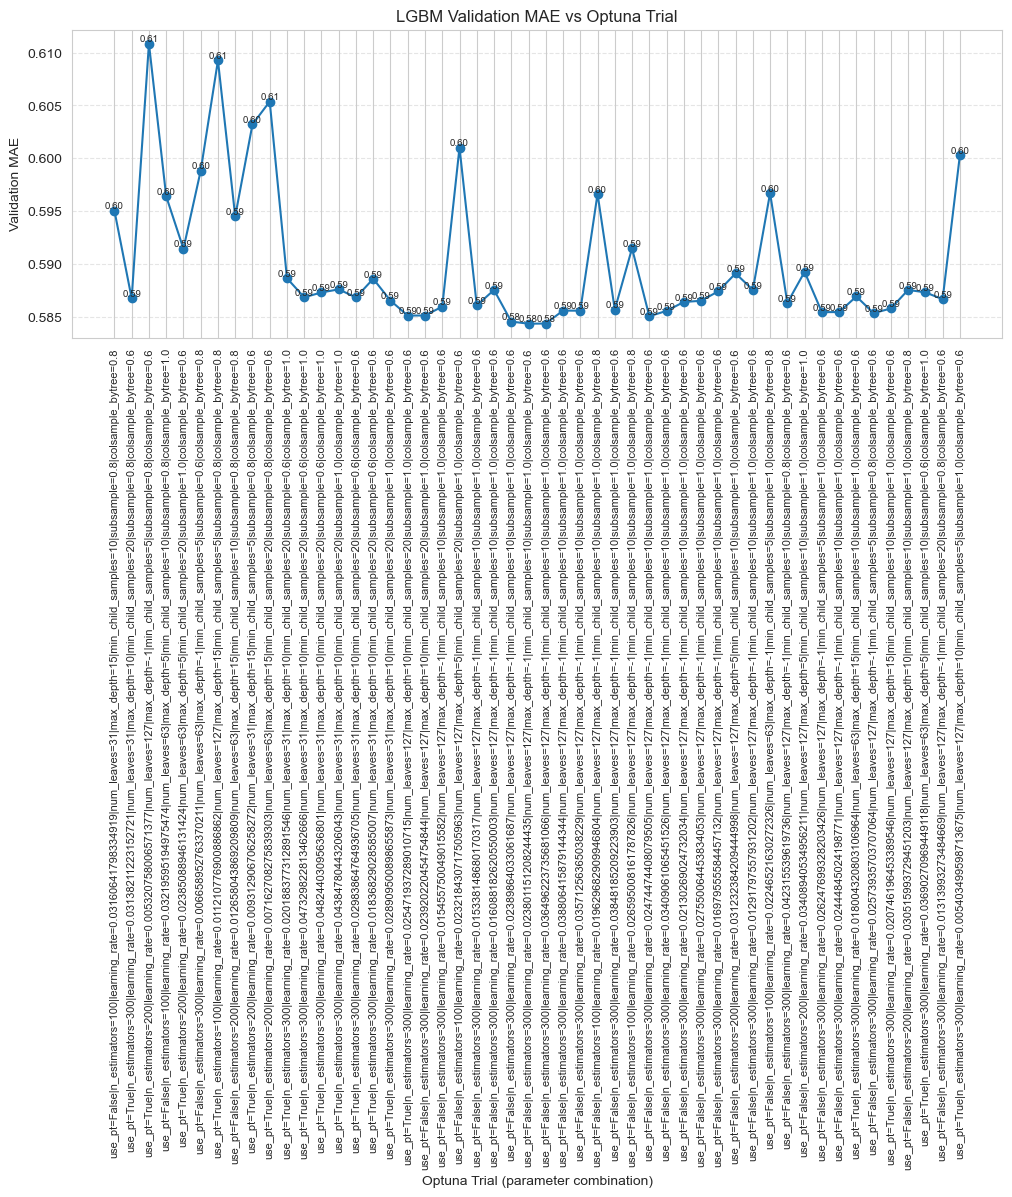

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


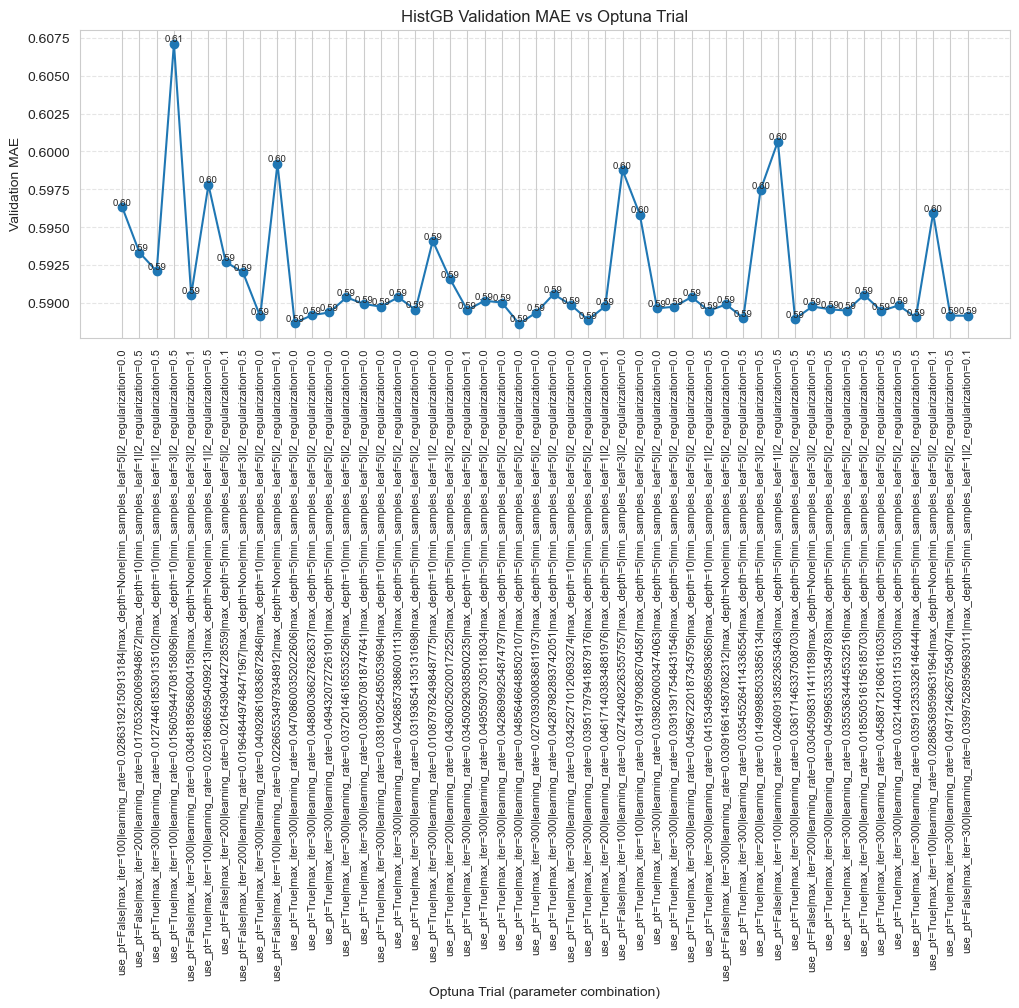

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


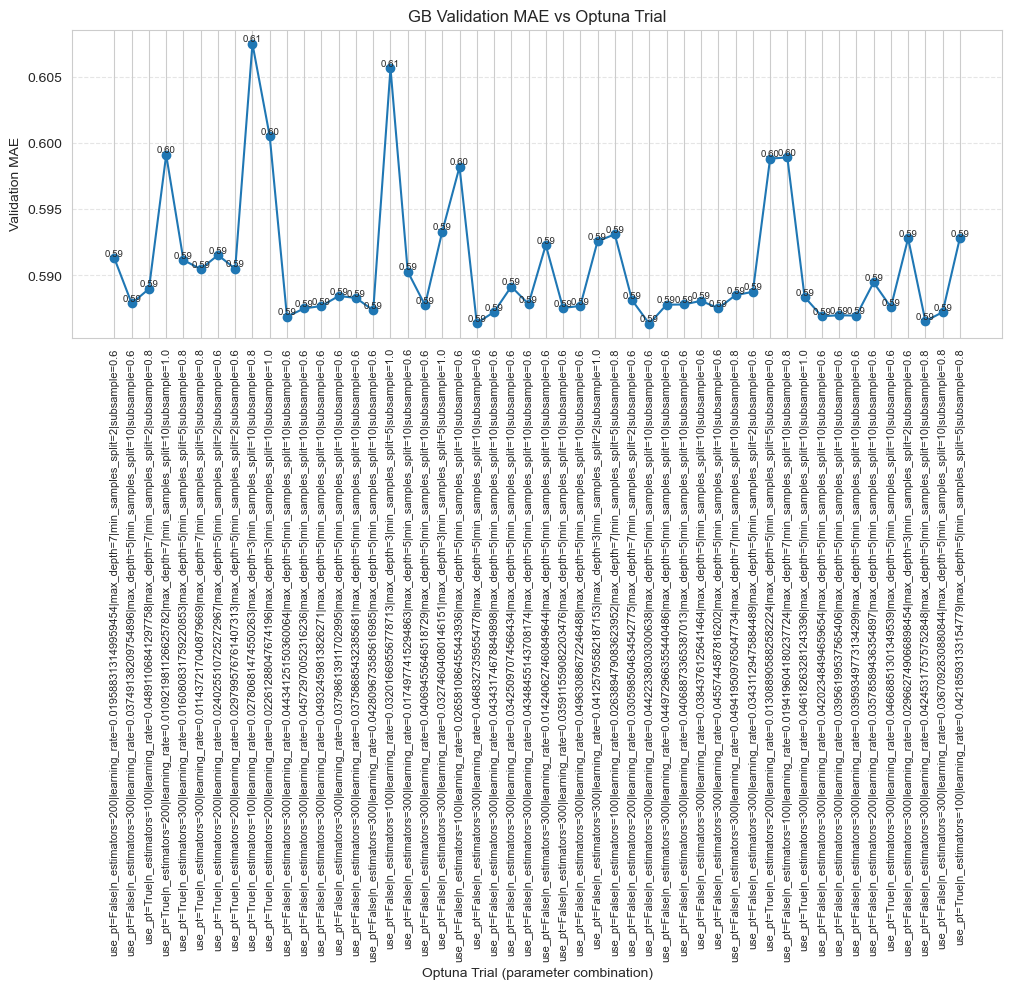

In [103]:
# 하이퍼파라미터 튜닝 시각화

for name, study in studies.items():
    # 1) trials 정보 추출
    records = []
    for t in study.trials:
        # trial.params 는 dict, trial.value 는 validation MAE
        combo = "|".join(f"{k}={v}" for k, v in t.params.items())
        records.append({
            "trial": t.number,
            "validation_MAE": t.value,
            "combo": combo
        })
    df_trials = pd.DataFrame(records)

    # 2) 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(df_trials["trial"], df_trials["validation_MAE"], marker="o", linestyle="-")
    plt.xticks(df_trials["trial"], df_trials["combo"], rotation=90, fontsize=8)
    plt.title(f"{name} Validation MAE vs Optuna Trial")
    plt.xlabel("Optuna Trial (parameter combination)")
    plt.ylabel("Validation MAE")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    for _, row in df_trials.iterrows():
        plt.text(row["trial"], row["validation_MAE"], f"{row['validation_MAE']:.2f}",
                 ha="center", va="bottom", fontsize=7)
    plt.tight_layout()
    plt.show()

In [104]:
best_estimators

{'Cat': Pipeline(steps=[('pt', PowerTransformer()),
                 ('model',
                  <catboost.core.CatBoostRegressor object at 0x15438b550>)]),
 'LGBM': Pipeline(steps=[('model',
                  LGBMRegressor(colsample_bytree=0.6,
                                learning_rate=0.023801151208244435,
                                min_child_samples=10, n_estimators=300,
                                num_leaves=127, random_state=42))]),
 'HistGB': Pipeline(steps=[('pt', PowerTransformer()),
                 ('model',
                  HistGradientBoostingRegressor(learning_rate=0.04856466488502107,
                                                max_depth=5, max_iter=300,
                                                min_samples_leaf=5,
                                                random_state=42))]),
 'GB': Pipeline(steps=[('model',
                  GradientBoostingRegressor(learning_rate=0.04422338030300638,
                                            max_depth=5,

In [105]:
cat_params = best_estimators['Cat'].get_params()
print(cat_params)

{'memory': None, 'steps': [('pt', PowerTransformer()), ('model', <catboost.core.CatBoostRegressor object at 0x15438b550>)], 'transform_input': None, 'verbose': False, 'pt': PowerTransformer(), 'model': <catboost.core.CatBoostRegressor object at 0x15438b550>, 'pt__copy': True, 'pt__method': 'yeo-johnson', 'pt__standardize': True, 'model__iterations': 800, 'model__learning_rate': 0.04665330906000037, 'model__depth': 6, 'model__l2_leaf_reg': 3, 'model__loss_function': 'RMSE', 'model__border_count': 64, 'model__verbose': False, 'model__bagging_temperature': 0.481288613144079, 'model__random_state': 42}


In [106]:
df_test

,test_MAE,test_MSE
model,,
Cat,2309.546540,1.484507e+08
LGBM,2310.477474,1.484048e+08
GB,2313.427246,1.484212e+08
HistGB,2320.572550,1.486334e+08


In [107]:
# 1) 테스트 MAE 최저 모델 이름
best_model_name = df_test['test_MAE'].idxmin()
best_model = best_estimators[best_model_name]

# 2) Validation MAE (Optuna) 와 Test MAE/MSE (df_test) 가져오기
validation_mae = studies[best_model_name].best_value
test_mae       = df_test.loc[best_model_name, 'test_MAE']
test_mse       = df_test.loc[best_model_name, 'test_MSE']

# 3) 튜닝된 파라미터
tuned_params = studies[best_model_name].best_params

print(f"최종 선택 모델       : {best_model_name}")
print(f"튜닝된 하이퍼파라미터 : {tuned_params}")
print(f"Validation MAE       : {validation_mae:.2f}")
print(f"Test MAE             : {test_mae:.2f}")
print(f"Test MSE             : {test_mse:.4e}")

최종 선택 모델       : Cat
튜닝된 하이퍼파라미터 : {'use_pt': True, 'depth': 6, 'learning_rate': 0.04665330906000037, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.481288613144079}
Validation MAE       : 0.58
Test MAE             : 2309.55
Test MSE             : 1.4845e+08


In [108]:
from itertools import combinations
from sklearn.ensemble import (
    StackingRegressor, VotingRegressor
)

# 1) Optuna 최적 파라미터 + use_pt 로 Pipeline 만들기
pipelines = {}
for name, study in studies.items():
    # 1.1 best_params 복사 & use_pt 분리
    best = study.best_params.copy()
    use_pt = best.pop('use_pt')
    # 1.2 모델 인스턴스 생성
    if name == 'Cat':
        mdl = CatBoostRegressor(**best, random_state=42, verbose=False)
    elif name == 'LGBM':
        mdl = LGBMRegressor(**best, random_state=42)
    elif name == 'HistGB':
        mdl = HistGradientBoostingRegressor(**best, random_state=42)
    else:
        mdl = GradientBoostingRegressor(**best, random_state=42)
    # 1.3 PT 여부에 따라 Pipeline 구성
    steps = []
    if use_pt:
        steps.append(('pt', PowerTransformer(method='yeo-johnson')))
    steps.append(('model', mdl))
    pipe = Pipeline(steps)
    # 1.4 TV(Train+Valid) 전체 데이터로 재학습
    pipe.fit(X_tv_proc, y_tv_proc)
    pipelines[name] = pipe

# 2) 앙상블: Stacking & Voting
ensemble_results = []
base_items = list(pipelines.items())
meta_models = {'Ridge': Ridge(), 'Lasso': Lasso()}

# 2.1 Stacking (2개,3개 조합)
for r in [2, 3]:
    for combo in tqdm(combinations(base_items, r), desc=f"Stacking r={r}", leave=False):
        names, pipes = zip(*combo)
        for meta_name, meta in meta_models.items():
            stack = StackingRegressor(
                estimators=list(zip(names, pipes)),
                final_estimator=meta,
                n_jobs=-1
            )
            stack.fit(X_tv_proc, y_tv_proc)
            y_pred = np.expm1(stack.predict(X_test_proc))
            ensemble_results.append({
                'type': f"Stack({'+'.join(names)})/{meta_name}",
                'MAE':  mean_absolute_error(y_test, y_pred)
            })

# 2.2 Voting (2개,3개 조합)
for r in [2, 3]:
    for combo in tqdm(combinations(base_items, r), desc=f"Voting r={r}", leave=False):
        names, pipes = zip(*combo)
        vote = VotingRegressor(estimators=list(zip(names, pipes)), n_jobs=-1)
        vote.fit(X_tv_proc, y_tv_proc)
        y_pred = np.expm1(vote.predict(X_test_proc))
        ensemble_results.append({
            'type': f"Vote({'+'.join(names)})",
            'MAE':  mean_absolute_error(y_test, y_pred)
        })

# 3) 결과 정리 및 출력
df_ens = pd.DataFrame(ensemble_results).sort_values('MAE').reset_index(drop=True)
pd.set_option('display.max_rows', None)
print("\n=== Ensemble Results ===")
print(df_ens.to_string(index=False))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Stacking r=2: 0it [00:00, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Stacking r=2: 3it [05:16, 118.10s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Stacking r=2: 4it [06:48, 107.71s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

Stacking r=3: 0it [00:00, ?it/s]     /opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Stacking r=3: 1it [01:40, 100.13s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007539 seconds.
You can se

Stacking r=3: 3it [08:50, 187.09s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Voting r=2: 0it [00:00, ?it/s]       

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=2: 3it [01:01, 26.51s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=2: 4it [01:05, 17.60s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=3: 0it [00:00, ?it/s]    

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=3: 1it [00:04,  4.58s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=3: 3it [01:52, 42.78s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042



=== Ensemble Results ===
                        type         MAE
Stack(Cat+LGBM+HistGB)/Ridge 2306.701946
       Stack(Cat+LGBM)/Ridge 2306.705737
    Stack(Cat+LGBM+GB)/Ridge 2306.725580
              Vote(Cat+LGBM) 2307.081674
           Vote(Cat+LGBM+GB) 2307.142159
  Stack(Cat+HistGB+GB)/Ridge 2308.185334
        Stack(LGBM+GB)/Ridge 2308.191301
         Stack(Cat+GB)/Ridge 2308.327541
 Stack(LGBM+HistGB+GB)/Ridge 2308.347574
                Vote(Cat+GB) 2308.790345
     Stack(Cat+HistGB)/Ridge 2308.841924
               Vote(LGBM+GB) 2308.864937
       Vote(Cat+LGBM+HistGB) 2308.961952
    Stack(LGBM+HistGB)/Ridge 2309.518412
         Vote(Cat+HistGB+GB) 2309.896673
        Vote(LGBM+HistGB+GB) 2310.617512
            Vote(Cat+HistGB) 2310.869570
      Stack(HistGB+GB)/Ridge 2312.360430
           Vote(LGBM+HistGB) 2312.456992
             Vote(HistGB+GB) 2313.777432
Stack(Cat+LGBM+HistGB)/Lasso 2450.819718
  Stack(Cat+HistGB+GB)/Lasso 2450.819718
       Stack(Cat+LGBM)/Lasso 24

In [110]:
best_ens = df_ens.iloc[0]
print(f"최종 앙상블: {best_ens['type']}  (Test MAE: {best_ens['MAE']:.4f})")

최종 앙상블: Stack(Cat+LGBM+HistGB)/Ridge  (Test MAE: 2306.7019)
